# RF and GBDT  on  DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [2]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

## 1.1 Reading Data (Considered 30K data)

In [219]:
project_data = pd.read_csv('train_data.csv',nrows=30000)
resource_data = pd.read_csv('resources.csv')


In [220]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (30000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [221]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
3287       159755  p147002  6ada7036aeb258d3653589d1f2a5b815           Mrs.   
19437      146532  p024903  55f60249d65840ee198285acdc455838           Mrs.   

      school_state                Date project_grade_category  \
3287            CA 2016-01-05 02:02:00             Grades 3-5   
19437           CA 2016-01-05 02:57:00             Grades 3-5   

                project_subject_categories  \
3287    Literacy & Language, Special Needs   
19437  Math & Science, Literacy & Language   

                     project_subject_subcategories  \
3287                       Literacy, Special Needs   
19437  Health & Life Science, Literature & Writing   

                      project_title  \
3287   Multimedia, Apps, and a Game   
19437              Colorful Writing   

                                         project_essay_1  \
3287   My students need new ways to learn. Research i...   
19437  My class is a diverse group of fifth and sixth...   

                                         project_essay_2  \
3287   My students are elementary students in kinderg...   
19437  Due to crowded living conditions, many of the ...   

                                         project_essay_3  \
3287   My students are pulled from their general educ...   
19437  Every child deserves the opportunity to learn ...   

                                         project_essay_4  \
3287   This donation will improve motivate my student...   
19437  By donating to this project, you are giving st...   

                                project_resource_summary  \
3287   My students need multimedia comprehension mate...   
19437    My students need ink to print their narratives.   

       teacher_number_of_previously_posted_projects  project_is_approved  
3287                                              2                    0  
19437                                             6                    1

In [222]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 preprocessing of `project_subject_categories`

In [223]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [224]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

### Preprocessing of `teacher_prefix`

In [225]:
#“Teacher prefix” data having the dots(.) and its has been observed the some rows are  empty in  this feature . 
#the dot(.) and  empty row available in the data consider as float datatype and it does not 
# accepted by the .Split() – Pandas function , so removing the same. 
# cleaning has been done for the same following references are used 
# 1.	Removing (.) from dataframe column - used ".str.replce" funtion (padas documentation)
# 2.	for  empty cell in datafram column - added the "Mrs." (in train data.cvs) which has me mostly occured in data set.

project_data["teacher_prefix_clean"] = project_data["teacher_prefix"].str.replace(".","")
project_data.head(2)
print(project_data.teacher_prefix_clean.shape)

(30000,)


## 1.4 Text preprocessing

In [226]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [227]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
3287       159755  p147002  6ada7036aeb258d3653589d1f2a5b815           Mrs.   
19437      146532  p024903  55f60249d65840ee198285acdc455838           Mrs.   

      school_state                Date project_grade_category  \
3287            CA 2016-01-05 02:02:00             Grades 3-5   
19437           CA 2016-01-05 02:57:00             Grades 3-5   

                      project_title  \
3287   Multimedia, Apps, and a Game   
19437              Colorful Writing   

                                         project_essay_1  \
3287   My students need new ways to learn. Research i...   
19437  My class is a diverse group of fifth and sixth...   

                                         project_essay_2  \
3287   My students are elementary students in kinderg...   
19437  Due to crowded living conditions, many of the ...   

                                         project_essay_3  \
3287   My students are pulled from their general educ...   
19437  Every child deserves the opportunity to learn ...   

                                         project_essay_4  \
3287   This donation will improve motivate my student...   
19437  By donating to this project, you are giving st...   

                                project_resource_summary  \
3287   My students need multimedia comprehension mate...   
19437    My students need ink to print their narratives.   

       teacher_number_of_previously_posted_projects  project_is_approved  \
3287                                              2                    0   
19437                                             6                    1   

                     clean_categories                    clean_subcategories  \
3287   Literacy_Language SpecialNeeds                  Literacy SpecialNeeds   
19437  Math_Science Literacy_Language  Health_LifeScience Literature_Writing   

      teacher_prefix_clean                                              essay  
3287                   Mrs  My students need new ways to learn. Research i...  
19437                  Mrs  My class is a diverse group of fifth and sixth...

In [228]:
# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)



My students need new ways to learn. Research indicates technology and games help improve student engagement.My students are elementary students in kindergarten through sixth grade who have been identified with a disability, such as ADHD, a learning disability, speech impairment, or autism. They attend a Title 1 school and about half are considered English learners. These students are able to learn but often in the less traditional way.My students are pulled from their general education classrooms to work on their academic skills. It is my hope that these materials will help motivate my students to learn. They will learn how to comprehend the various forms of literacy, learn various academic skills with educational apps, and improve their literacy skills.This donation will improve motivate my students to learn and increase student engagement. In addition, their academic skills and social skills will be enhanced through these materials and better prepare them for life.
A soft-spoken voic

In [229]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [230]:
sent = decontracted(project_data['essay'].values[2000])
print(sent)
print("="*50)

What would a Kindergarten classroom be without a dramatic play area? Currently, my classroom does not have any dramatic play supplies. In addition to learning to read, write, add, and subtract, kindergartners need to opportunity to learn and express themselves through dramatic play.\r\nMy students are fantastic!\r\nThey are a creative group of kids who are eager to learn. I work in a   Title-1 school with 90% of the students with free  Breakfast and Lunch. My students deserve the best! Without a dramatic play area, my students miss out on an important piece of growing and learning. These supplies (kitchen set, shop stand, and play food) will enhance the learning in my classroom by giving the students real life experiences which will provide them with an opportunity to learn through social interaction and dramatic play. Please help support this project.\r\n\r\n\r\nDuring the Kindergarten day, there is a time for learning centers. During this time, the students learn through self discove

In [231]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

What would a Kindergarten classroom be without a dramatic play area? Currently, my classroom does not have any dramatic play supplies. In addition to learning to read, write, add, and subtract, kindergartners need to opportunity to learn and express themselves through dramatic play.  My students are fantastic!  They are a creative group of kids who are eager to learn. I work in a   Title-1 school with 90% of the students with free  Breakfast and Lunch. My students deserve the best! Without a dramatic play area, my students miss out on an important piece of growing and learning. These supplies (kitchen set, shop stand, and play food) will enhance the learning in my classroom by giving the students real life experiences which will provide them with an opportunity to learn through social interaction and dramatic play. Please help support this project.      During the Kindergarten day, there is a time for learning centers. During this time, the students learn through self discovery and pla

In [232]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

What would a Kindergarten classroom be without a dramatic play area Currently my classroom does not have any dramatic play supplies In addition to learning to read write add and subtract kindergartners need to opportunity to learn and express themselves through dramatic play My students are fantastic They are a creative group of kids who are eager to learn I work in a Title 1 school with 90 of the students with free Breakfast and Lunch My students deserve the best Without a dramatic play area my students miss out on an important piece of growing and learning These supplies kitchen set shop stand and play food will enhance the learning in my classroom by giving the students real life experiences which will provide them with an opportunity to learn through social interaction and dramatic play Please help support this project During the Kindergarten day there is a time for learning centers During this time the students learn through self discovery and play Currently my classroom does not 

In [233]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

### 1.4.1  Data Pracessing (Essay) 

In [234]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|████████████████████████████████████████████████████████| 30000/30000 [00:15<00:00, 1894.67it/s]


In [235]:
project_data["preprocessed_essays"] = preprocessed_essays

In [236]:
project_data.shape

(30000, 20)

### 1.4.2 Words in the Essay

In [237]:
# https://stackoverflow.com/questions/49984905/count-number-of-words-per-row/49984998
project_data['essay_word_count'] = [len(x.split()) for x in project_data['preprocessed_essays'].tolist()]

In [238]:
project_data.shape

(30000, 21)

In [239]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
3287       159755  p147002  6ada7036aeb258d3653589d1f2a5b815           Mrs.   
19437      146532  p024903  55f60249d65840ee198285acdc455838           Mrs.   

      school_state                Date project_grade_category  \
3287            CA 2016-01-05 02:02:00             Grades 3-5   
19437           CA 2016-01-05 02:57:00             Grades 3-5   

                      project_title  \
3287   Multimedia, Apps, and a Game   
19437              Colorful Writing   

                                         project_essay_1  \
3287   My students need new ways to learn. Research i...   
19437  My class is a diverse group of fifth and sixth...   

                                         project_essay_2       ...         \
3287   My students are elementary students in kinderg...       ...          
19437  Due to crowded living conditions, many of the ...       ...          

                                         project_essay_4  \
3287   This donation will improve motivate my student...   
19437  By donating to this project, you are giving st...   

                                project_resource_summary  \
3287   My students need multimedia comprehension mate...   
19437    My students need ink to print their narratives.   

      teacher_number_of_previously_posted_projects  project_is_approved  \
3287                                             2                    0   
19437                                            6                    1   

                     clean_categories                    clean_subcategories  \
3287   Literacy_Language SpecialNeeds                  Literacy SpecialNeeds   
19437  Math_Science Literacy_Language  Health_LifeScience Literature_Writing   

      teacher_prefix_clean                                              essay  \
3287                   Mrs  My students need new ways to learn. Research i...   
19437                  Mrs  My class is a diverse group of fifth and sixth...   

                                     preprocessed_essays essay_word_count  
3287   my students need new ways learn research indic...               97  
19437  my class diverse group fifth sixth graders inc...              176  

[2 rows x 21 columns]

<h2><font color='red'> 1.5 Preprocessing of `project_title`</font></h2>

In [240]:
# Data processing for project titles 
Title_clean = project_data.project_title
Title_clean.head(2)

3287     Multimedia, Apps, and a Game
19437                Colorful Writing
Name: project_title, dtype: object

In [241]:
P = decontracted(project_data['project_title'].values[1])
print(P)

Colorful Writing


In [242]:
# \r \n \t  and -- remove from string python: http://texthandler.com/info/remove-line-breaks-python/
P = P.replace('\\r', ' ')
P = P.replace('\\"', ' ')
P = P.replace('\\n', ' ')
P = P.replace('--', ' ')
print(P)

Colorful Writing


### 1.5.1  Data Pracessing (Project Title) 

In [243]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_Titles = []
# tqdm is for printing the status bar
for Pance in tqdm(project_data['project_title'].values):
    P = decontracted(Pance)
    P = P.replace('\\r', ' ')
    P = P.replace('\\"', ' ')
    P = P.replace('\\n', ' ')
    P = re.sub('[^A-Za-z0-9]+', ' ', P)
    # https://gist.github.com/sebleier/554280
    P = ' '.join(e for e in P.split() if e not in stopwords)
    preprocessed_Titles.append(P.lower().strip())

100%|███████████████████████████████████████████████████████| 30000/30000 [00:00<00:00, 41647.62it/s]


In [244]:
project_data["preprocessed_Titles"] = preprocessed_Titles

### 1.5.2 Words in the Project Title

In [245]:
project_data['title_word_count'] = [len(x.split()) for x in project_data['preprocessed_Titles'].tolist()]

In [246]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
3287       159755  p147002  6ada7036aeb258d3653589d1f2a5b815           Mrs.   
19437      146532  p024903  55f60249d65840ee198285acdc455838           Mrs.   

      school_state                Date project_grade_category  \
3287            CA 2016-01-05 02:02:00             Grades 3-5   
19437           CA 2016-01-05 02:57:00             Grades 3-5   

                      project_title  \
3287   Multimedia, Apps, and a Game   
19437              Colorful Writing   

                                         project_essay_1  \
3287   My students need new ways to learn. Research i...   
19437  My class is a diverse group of fifth and sixth...   

                                         project_essay_2       ...         \
3287   My students are elementary students in kinderg...       ...          
19437  Due to crowded living conditions, many of the ...       ...          

      teacher_number_of_previously_posted_projects project_is_approved  \
3287                                             2                   0   
19437                                            6                   1   

                     clean_categories                    clean_subcategories  \
3287   Literacy_Language SpecialNeeds                  Literacy SpecialNeeds   
19437  Math_Science Literacy_Language  Health_LifeScience Literature_Writing   

       teacher_prefix_clean  \
3287                    Mrs   
19437                   Mrs   

                                                   essay  \
3287   My students need new ways to learn. Research i...   
19437  My class is a diverse group of fifth and sixth...   

                                     preprocessed_essays essay_word_count  \
3287   my students need new ways learn research indic...               97   
19437  my class diverse group fifth sixth graders inc...              176   

        preprocessed_Titles title_word_count  
3287   multimedia apps game                3  
19437      colorful writing                2  

[2 rows x 23 columns]

**Train , Cross Validation and Test Data Split**

In [247]:
#As recommended in the Lecture video, splitting the Data in Train, Test and Cross validation data set
#before applying Vectorization to avoid the data leakage issues.
# As suggested to use stratify sampling, Referred following site for code
# https://stackoverflow.com/questions/29438265/stratified-train-test-split-in-scikit-learn



# split the data set into train and test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(project_data, project_data['project_is_approved'], test_size=0.33,stratify = project_data['project_is_approved'
])

# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(X_train, y_train, test_size=0.33,stratify=y_train)


## 1.6 Preparing data for models

In [248]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'teacher_prefix_clean',
       'essay', 'preprocessed_essays', 'essay_word_count',
       'preprocessed_Titles', 'title_word_count'],
      dtype='object')

### 1.6.1 Vectorizing Text data

#### 1.6.1.1 Bag of words

**Train Data Vectorization - BOW (essays)**

In [249]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer_bow_essay = CountVectorizer(min_df=10)

bow_essays_train = vectorizer_bow_essay.fit_transform(X_train["preprocessed_essays"])
print("Shape of matrix after one hot encodig ",bow_essays_train.shape)

Shape of matrix after one hot encodig  (13467, 7111)


**CV Data Vectorization - BOW (essays)**

In [250]:
bow_essays_cv = vectorizer_bow_essay.transform(X_cv["preprocessed_essays"])
print("Shape of matrix after one hot encodig ",bow_essays_cv.shape)

Shape of matrix after one hot encodig  (6633, 7111)


**Test Data Vectorization - BOW (essays)**

In [251]:
bow_essays_test = vectorizer_bow_essay.transform(X_test["preprocessed_essays"])
print("Shape of matrix after one hot encoding ",bow_essays_test.shape)

Shape of matrix after one hot encoding  (9900, 7111)


**Train Data Vectorization - BOW (Project Titles)**

In [252]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer_bow_title = CountVectorizer(min_df=10)
bow_title_train = vectorizer_bow_title.fit_transform(X_train["preprocessed_Titles"])
print("Shape of matrix after one hot encodig ",bow_title_train.shape)

Shape of matrix after one hot encodig  (13467, 832)


**CV Data Vectorization - BOW (Project Titles)**

In [253]:
bow_title_cv = vectorizer_bow_title.transform(X_cv["preprocessed_Titles"])
print("Shape of matrix after one hot encodig ",bow_title_cv.shape)

Shape of matrix after one hot encodig  (6633, 832)


**Test Data Vectorization - BOW (Project Titles)**

In [254]:
bow_title_test = vectorizer_bow_title.transform(X_test["preprocessed_Titles"])
print("Shape of matrix after one hot encodig ",bow_title_test.shape)

Shape of matrix after one hot encodig  (9900, 832)


#### 1.6.1.2 TFIDF vectorizer

**Train Data Vectorization - TFIDF (essays)**

In [255]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf_essay = TfidfVectorizer(min_df=10)
tfidf_essays_train = vectorizer_tfidf_essay.fit_transform(X_train["preprocessed_essays"])
print("Shape of matrix after one hot encodig ",tfidf_essays_train.shape)

Shape of matrix after one hot encodig  (13467, 7111)


**CV Data Vectorization - TFIDF (essays)**

In [256]:
tfidf_essays_cv = vectorizer_tfidf_essay.transform(X_cv["preprocessed_essays"])
print("Shape of matrix after one hot encodig ",tfidf_essays_cv.shape)

Shape of matrix after one hot encodig  (6633, 7111)


**Test Data Vectorization - TFIDF (essays)**

In [257]:
tfidf_essays_test = vectorizer_tfidf_essay.transform(X_test["preprocessed_essays"])
print("Shape of matrix after one hot encodig ",tfidf_essays_test.shape)

Shape of matrix after one hot encodig  (9900, 7111)


**Train Data Vectorization - TFIDF (Project Titles)**

In [258]:
vectorizer_tfidf_title = CountVectorizer(min_df=10)
tfidf_title_train = vectorizer_tfidf_title.fit_transform(X_train["preprocessed_Titles"])
print("Shape of matrix after one hot encodig ",bow_title_train.shape)

Shape of matrix after one hot encodig  (13467, 832)


**CV Data Vectorization - TFIDF (Project Titles)**

In [259]:
tfidf_title_cv = vectorizer_tfidf_title.transform(X_cv["preprocessed_Titles"])
print("Shape of matrix after one hot encodig ",bow_title_cv.shape)

Shape of matrix after one hot encodig  (6633, 832)


**Test Data Vectorization - TFIDF (Project Titles)**

In [260]:
tfidf_title_test = vectorizer_tfidf_title.transform(X_test["preprocessed_Titles"])
print("Shape of matrix after one hot encodig ",bow_title_test.shape)

Shape of matrix after one hot encodig  (9900, 832)


#### 1.6.1.3 Using Pretrained Models: Avg W2V

In [45]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039

def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')


Loading Glove Model


1917495it [03:41, 8676.37it/s]


Done. 1917495  words loaded!


In [46]:
words = []
for i in X_train["preprocessed_essays"]:
    words.extend(i.split(' '))

for i in X_train["preprocessed_essays"]:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))

all the words in the coupus 4435736
the unique words in the coupus 26080
The number of words that are present in both glove vectors and our coupus 24910 ( 95.514 %)
word 2 vec length 24910


In [47]:
words = []
for i in X_train["preprocessed_Titles"]:
    words.extend(i.split(' '))

for i in X_train["preprocessed_Titles"]:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))

all the words in the coupus 127156
the unique words in the coupus 6609
The number of words that are present in both glove vectors and our coupus 6454 ( 97.655 %)
word 2 vec length 6454


In [48]:
import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)

In [49]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

**Train Data Vectorization - AGV_W2V (essays)**

In [261]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_essays_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train["preprocessed_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_essays_train.append(vector)

print(len(avg_w2v_essays_train))
print(len(avg_w2v_essays_train[0]))

100%|████████████████████████████████████████████████████████| 13467/13467 [00:03<00:00, 4238.13it/s]


13467
300


**CV Data Vectorization - AGV_W2V (essays)**

In [262]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_essays_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv["preprocessed_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_essays_cv.append(vector)

print(len(avg_w2v_essays_cv))
print(len(avg_w2v_essays_cv[0]))

100%|██████████████████████████████████████████████████████████| 6633/6633 [00:01<00:00, 3985.20it/s]


6633
300


**Test Data Vectorization - AGV_W2V (essays)**

In [263]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_essays_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test["preprocessed_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_essays_test.append(vector)

print(len(avg_w2v_essays_test))
print(len(avg_w2v_essays_test[0]))

100%|██████████████████████████████████████████████████████████| 9900/9900 [00:02<00:00, 4047.59it/s]


9900
300


**Train Data Vectorization - AGV_W2V (Project Titles)**

In [264]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_title_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train["preprocessed_Titles"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_train.append(vector)

print(len(avg_w2v_title_train))
print(len(avg_w2v_title_train[0]))


100%|███████████████████████████████████████████████████████| 13467/13467 [00:00<00:00, 70343.40it/s]


13467
300


**CV Data Vectorization - AGV_W2V (Project Titles)**

In [265]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_title_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv["preprocessed_Titles"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_cv.append(vector)

print(len(avg_w2v_title_cv))
print(len(avg_w2v_title_cv[0]))

100%|█████████████████████████████████████████████████████████| 6633/6633 [00:00<00:00, 75478.63it/s]


6633
300


**Test Data Vectorization - AGV_W2V (Project Titles)**

In [266]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_title_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test["preprocessed_Titles"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_title_test.append(vector)

print(len(avg_w2v_title_test))
print(len(avg_w2v_title_test[0]))

100%|█████████████████████████████████████████████████████████| 9900/9900 [00:00<00:00, 65218.55it/s]


9900
300


#### 1.6.1.3 Using Pretrained Models: TFIDF weighted W2V

In [267]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train["preprocessed_essays"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

**Train Data Vectorization - TFIDF_W2V (essays)**

In [268]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_essays_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train["preprocessed_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_essays_train.append(vector)

print(len(tfidf_w2v_essays_train))
print(len(tfidf_w2v_essays_train[0]))

100%|█████████████████████████████████████████████████████████| 13467/13467 [00:22<00:00, 590.96it/s]


13467
300


**CV Data Vectorization - TFIDF_W2V (essays)**

In [269]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_essays_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv["preprocessed_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_essays_cv.append(vector)

print(len(tfidf_w2v_essays_cv))
print(len(tfidf_w2v_essays_cv[0]))

100%|███████████████████████████████████████████████████████████| 6633/6633 [00:11<00:00, 588.78it/s]


6633
300


**Test Data Vectorization - TFIDF_W2V (essays)**

In [270]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_essays_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test["preprocessed_essays"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_essays_test.append(vector)

print(len(tfidf_w2v_essays_test))
print(len(tfidf_w2v_essays_test[0]))

100%|███████████████████████████████████████████████████████████| 9900/9900 [00:16<00:00, 595.19it/s]


9900
300


In [271]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train["preprocessed_Titles"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words_titles = set(tfidf_model.get_feature_names())

**Train Data Vectorization - TFIDF_W2V (Project Titles)**

In [272]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_title_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train["preprocessed_Titles"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_titles):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_train.append(vector)

print(len(tfidf_w2v_title_train))
print(len(tfidf_w2v_title_train[0]))


100%|███████████████████████████████████████████████████████| 13467/13467 [00:00<00:00, 34868.41it/s]


13467
300


**CV Data Vectorization - TFIDF_W2V (Project Titles)**

In [273]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_title_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv["preprocessed_Titles"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_titles ):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_cv.append(vector)

print(len(tfidf_w2v_title_cv))
print(len(tfidf_w2v_title_cv[0]))

100%|█████████████████████████████████████████████████████████| 6633/6633 [00:00<00:00, 33833.46it/s]


6633
300


**Test Data Vectorization - TFIDF_W2V (Project Titles)**

In [274]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_title_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test["preprocessed_Titles"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_titles):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_test.append(vector)

print(len(tfidf_w2v_title_test))
print(len(tfidf_w2v_title_test[0]))

100%|█████████████████████████████████████████████████████████| 9900/9900 [00:00<00:00, 36781.58it/s]


9900
300


### 1.6.2 Vectorizing Numerical features

### 1.6.2.1 Vectorizing Numerical features - Price 

In [275]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

# Merging the project data train , Cv , test with price from resource data 
X_train = pd.merge(X_train, price_data, on='id', how='left')
X_cv = pd.merge(X_cv, price_data, on='id', how='left')
X_test = pd.merge(X_test, price_data, on='id', how='left')



In [276]:
X_train.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      169306  p221374  cdd537a38dd777ab82bde350ef0bca81           Mrs.   
1       10913  p176797  676a4235f7e8ecb6eae1d144314a9c0a            Ms.   

  school_state                Date project_grade_category  \
0           IN 2016-07-08 11:15:00          Grades PreK-2   
1           IL 2016-06-30 14:08:00             Grades 6-8   

                    project_title  \
0           Movement At Your Seat   
1  Need Translation? No Problemo!   

                                     project_essay_1  \
0  My students have a wide arrange of abilities a...   
1  In a predominantly bilingual community, litera...   

                                     project_essay_2   ...     \
0  I would like this type of seating in our class...   ...      
1  The large majority of our students are bilingu...   ...      

    clean_categories clean_subcategories teacher_prefix_clean  \
0      Health_Sports     Health_Wellness                  Mrs   
1  Literacy_Language        ESL Literacy                   Ms   

                                               essay  \
0  My students have a wide arrange of abilities a...   
1  In a predominantly bilingual community, litera...   

                                 preprocessed_essays essay_word_count  \
0  my students wide arrange abilities academicall...              112   
1  in predominantly bilingual community literacy ...              124   

            preprocessed_Titles title_word_count   price quantity  
0         movement at your seat                4  110.46        7  
1  need translation no problemo                4   33.27      106  

[2 rows x 25 columns]

In [277]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(-1,1))

price_train = normalizer.transform(X_train['price'].values.reshape(-1,1))
price_cv = normalizer.transform(X_cv['price'].values.reshape(-1,1))
price_test = normalizer.transform(X_test['price'].values.reshape(-1,1))

print(price_train.shape)
print(price_cv.shape)
print(price_test.shape)

(13467, 1)
(6633, 1)
(9900, 1)


### 1.6.2.2 Vectorizing Numerical features - teacher_number_of_previously_posted_projects

In [278]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

prev_post_train = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_post_cv = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
prev_post_test = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print(prev_post_train.shape)
print(prev_post_cv.shape)
print(prev_post_test.shape)

(13467, 1)
(6633, 1)
(9900, 1)


### 1.6.2.3 Vectorizing Numerical features - Quantity

In [279]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['quantity'].values.reshape(-1,1))

Quantity_train = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
Quantity_cv = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
Quantity_test = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print(Quantity_train.shape)
print(Quantity_cv.shape)
print(Quantity_test.shape)

(13467, 1)
(6633, 1)
(9900, 1)


### 1.6.2.4 Vectorizing Numerical features - Project Title word count 

In [280]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['title_word_count'].values.reshape(-1,1))

title_word_count_train = normalizer.transform(X_train['title_word_count'].values.reshape(-1,1))
title_word_count_cv = normalizer.transform(X_cv['title_word_count'].values.reshape(-1,1))
title_word_count_test = normalizer.transform(X_test['title_word_count'].values.reshape(-1,1))

print(title_word_count_train.shape)
print(title_word_count_cv.shape)
print(title_word_count_test.shape)

(13467, 1)
(6633, 1)
(9900, 1)


### 1.6.2.5 Vectorizing Numerical features - Essay word count 

In [281]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['essay_word_count'].values.reshape(-1,1))

essay_word_count_train = normalizer.transform(X_train['essay_word_count'].values.reshape(-1,1))
essay_word_count_cv = normalizer.transform(X_cv['essay_word_count'].values.reshape(-1,1))
essay_word_count_test = normalizer.transform(X_test['essay_word_count'].values.reshape(-1,1))

print(essay_word_count_train.shape)
print(essay_word_count_cv.shape)
print(essay_word_count_test.shape)


(13467, 1)
(6633, 1)
(9900, 1)


### 1.6.3 Categorical features - Response Coding 

In [282]:
#Followed the Implementation Steps provided by Applied AI Team
  
#1.Consider each categorical feature separately from the train dataset

#2.Find the probability of each category based on the class_labels('0' and '1')

#3.Generate "Class_0" and "Class_1" values for each type of category.

#4.Append those class_0 and class_1 values for a particular category of categorical feature
#which is present in the train data and test data and Cv data.

#5. If there is a new category in your test data, consider 0.5, 0.5 as it's value


**1.6.3.1 Project_categories - Response Coding**

**Finding the positive and negative classes**

In [283]:
X_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'teacher_prefix_clean',
       'essay', 'preprocessed_essays', 'essay_word_count',
       'preprocessed_Titles', 'title_word_count', 'price', 'quantity'],
      dtype='object')

In [284]:
X_train_PC = X_train.loc[X_train['project_is_approved'] == 1]

In [285]:
clean_category_PC = {}

for a in X_train_PC['clean_categories'] :
    for b in a.split():
        if b not in clean_category_PC :
            clean_category_PC[b] = 1
        else :
            clean_category_PC[b] += 1


In [286]:
X_train_NC = X_train.loc[X_train['project_is_approved'] == 0]

In [287]:
clean_category_NC = {}

for a in X_train_NC['clean_categories'] :
    for b in a.split():
        if b not in clean_category_NC :
            clean_category_NC[b] = 1
        else :
            clean_category_NC[b] += 1

In [288]:
clean_category_total = {}

for a in X_train['clean_categories'] :
    for b in a.split():
        if b not in clean_category_total :
            clean_category_total[b] = 1
        else :
            clean_category_total[b] += 1

**Finding Probability for positive and negative class**

In [289]:
PC_prob_category = {}

for pc in clean_category_total.keys():
    PC_prob_category[pc] = (clean_category_PC[pc])/float(clean_category_total[pc])

In [290]:
NC_prob_category = {}

for nc in clean_category_total.keys():
    NC_prob_category[nc] = (clean_category_NC[nc])/float(clean_category_total[nc])

**Train data- Applying Probability**

In [291]:
cat_nc_train = []
cat_pc_train = []

for a in X_train["clean_categories"] :
    b = a.split()
    if len(b) == 1 :
        cat_nc_train.append(NC_prob_category[a])
        cat_pc_train.append(PC_prob_category[a])
    else :
        c = NC_prob_category[b[0]]
        d = NC_prob_category[b[1]]
        e = PC_prob_category[b[0]]
        f = PC_prob_category[b[1]]
        
        cat_nc_train.append(c*d)
        cat_pc_train.append(e*f)

In [292]:
X_train["cat_nc_train"] = cat_nc_train
X_train["cat_pc_train"] = cat_pc_train

**cv data- Applying Probability**

In [293]:
cat_nc_cv = []
cat_pc_cv = []

for a in X_cv["clean_categories"] :
    b = a.split()
    if len(b) == 1 :
        cat_nc_cv.append(NC_prob_category[a])
        cat_pc_cv.append(PC_prob_category[a])
    else :
        c = NC_prob_category[b[0]]
        d = NC_prob_category[b[1]]
        e = PC_prob_category[b[0]]
        f = PC_prob_category[b[1]]
        
        cat_nc_cv.append(c*d)
        cat_pc_cv.append(e*f)


In [294]:
X_cv["cat_nc_cv"] = cat_nc_cv
X_cv["cat_pc_cv"] = cat_pc_cv

**Test data- Applying Probability**

In [295]:
cat_nc_test = []
cat_pc_test = []

for a in X_test["clean_categories"] :
    b = a.split()
    if len(b) == 1 :
        cat_nc_test.append(NC_prob_category[a])
        cat_pc_test.append(PC_prob_category[a])
    else :
        c = NC_prob_category[b[0]]
        d = NC_prob_category[b[1]]
        e = PC_prob_category[b[0]]
        f = PC_prob_category[b[1]]
        
        cat_nc_test.append(c*d)
        cat_pc_test.append(e*f)

In [296]:
X_test["cat_nc_test"] = cat_nc_test
X_test["cat_pc_test"] = cat_pc_test


**Negative Class - Normalization**

In [297]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train["cat_nc_train"].values.reshape(-1,1))

cat_nc_train = normalizer.transform(X_train["cat_nc_train"].values.reshape(-1,1))
cat_nc_cv= normalizer.transform(X_cv["cat_nc_cv"].values.reshape(-1,1))
cat_nc_test = normalizer.transform(X_test["cat_nc_test"].values.reshape(-1,1))


print("After vectorizations")
print(cat_nc_train.shape)
print(cat_nc_cv.shape)
print(cat_nc_test.shape)

After vectorizations
(13467, 1)
(6633, 1)
(9900, 1)


**Positive Class - Normalization**

In [298]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train["cat_pc_train"].values.reshape(-1,1))

cat_pc_train = normalizer.transform(X_train["cat_pc_train"].values.reshape(-1,1))
cat_pc_cv= normalizer.transform(X_cv["cat_pc_cv"].values.reshape(-1,1))
cat_pc_test = normalizer.transform(X_test["cat_pc_test"].values.reshape(-1,1))


print("After vectorizations")
print(cat_pc_train.shape)
print(cat_pc_cv.shape)
print(cat_pc_test.shape)


After vectorizations
(13467, 1)
(6633, 1)
(9900, 1)


**1.6.3.2 Project_sub_categories - Response Coding**

In [299]:
clean_subcategory_PC = {}

for a in X_train_PC['clean_subcategories'] :
    for b in a.split():
        if b not in clean_subcategory_PC :
            clean_subcategory_PC[b] = 1
        else :
            clean_subcategory_PC[b] += 1

In [300]:
clean_subcategory_NC = {}

for a in X_train_NC['clean_subcategories'] :
    for b in a.split():
        if b not in clean_subcategory_NC :
            clean_subcategory_NC[b] = 1
        else :
            clean_subcategory_NC[b] += 1

In [301]:
clean_subcategory_total = {}

for a in X_train['clean_subcategories'] :
    for b in a.split():
        if b not in clean_subcategory_total :
            clean_subcategory_total[b] = 1
        else :
            clean_subcategory_total[b] += 1

**Finding Probability for positive and negative class**


In [302]:
PC_prob_subcategory = {}

for pc in clean_subcategory_total.keys():
    PC_prob_subcategory[pc] = (clean_subcategory_PC[pc])/float(clean_subcategory_total[pc])

In [303]:
NC_prob_subcategory = {}

for nc in clean_subcategory_total.keys():
    NC_prob_subcategory[nc] = (clean_subcategory_NC[nc])/float(clean_subcategory_total[nc])

**Train data- Applying Probability**


In [304]:
subcat_nc_train = []
subcat_pc_train = []

for a in X_train["clean_subcategories"] :
    b = a.split()
    if len(b) == 1 :
        subcat_nc_train.append(NC_prob_subcategory[a])
        subcat_pc_train.append(PC_prob_subcategory[a])
    else :
        c = NC_prob_subcategory[b[0]]
        d = NC_prob_subcategory[b[1]]
        e = PC_prob_subcategory[b[0]]
        f = PC_prob_subcategory[b[1]]
        
        subcat_nc_train.append(c*d)
        subcat_pc_train.append(e*f)

In [305]:
X_train["subcat_nc_train"] = subcat_nc_train
X_train["subcat_pc_train"] = subcat_pc_train

**cv data- Applying Probability**


In [306]:
subcat_nc_cv = []
subcat_pc_cv = []

for a in X_cv["clean_subcategories"] :
    b = a.split()
    if len(b) == 1 :
        subcat_nc_cv.append(NC_prob_subcategory[a])
        subcat_pc_cv.append(PC_prob_subcategory[a])
    else :
        c = NC_prob_subcategory[b[0]]
        d = NC_prob_subcategory[b[1]]
        e = PC_prob_subcategory[b[0]]
        f = PC_prob_subcategory[b[1]]
        
        subcat_nc_cv.append(c*d)
        subcat_pc_cv.append(e*f)

In [307]:
X_cv["subcat_nc_cv"] = subcat_nc_cv
X_cv["subcat_pc_cv"] = subcat_pc_cv

**test data- Applying Probability**

In [308]:
subcat_nc_test = []
subcat_pc_test = []

for a in X_test["clean_subcategories"] :
    b = a.split()
    if len(b) == 1 :
        subcat_nc_test.append(NC_prob_subcategory[a])
        subcat_pc_test.append(PC_prob_subcategory[a])
    else :
        c = NC_prob_subcategory[b[0]]
        d = NC_prob_subcategory[b[1]]
        e = PC_prob_subcategory[b[0]]
        f = PC_prob_subcategory[b[1]]
        
        subcat_nc_test.append(c*d)
        subcat_pc_test.append(e*f)

In [309]:
X_test["subcat_nc_test"] = subcat_nc_test
X_test["subcat_pc_test"] = subcat_pc_test

**Negative Class - Normalization**

In [310]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train["subcat_nc_train"].values.reshape(-1,1))

subcat_nc_train = normalizer.transform(X_train["subcat_nc_train"].values.reshape(-1,1))
subcat_nc_cv= normalizer.transform(X_cv["subcat_nc_cv"].values.reshape(-1,1))
subcat_nc_test = normalizer.transform(X_test["subcat_nc_test"].values.reshape(-1,1))


print("After vectorizations")
print(subcat_nc_train.shape)
print(subcat_nc_cv.shape)
print(subcat_nc_test.shape)

After vectorizations
(13467, 1)
(6633, 1)
(9900, 1)


**Positive Class - Normalization**

In [311]:
normalizer.fit(X_train["subcat_pc_train"].values.reshape(-1,1))

subcat_pc_train = normalizer.transform(X_train["subcat_pc_train"].values.reshape(-1,1))
subcat_pc_cv= normalizer.transform(X_cv["subcat_pc_cv"].values.reshape(-1,1))
subcat_pc_test = normalizer.transform(X_test["subcat_pc_test"].values.reshape(-1,1))


print("After vectorizations")
print(subcat_pc_train.shape)
print(subcat_pc_cv.shape)
print(subcat_pc_test.shape)


After vectorizations
(13467, 1)
(6633, 1)
(9900, 1)


**1.6.3.3 School_State - Response Coding** 

In [312]:
school_state_PC = {}

for a in X_train_PC['school_state'] :
    
        if a not in school_state_PC :
            school_state_PC[a] = 1
        else :
            school_state_PC[a] += 1

In [313]:
school_state_NC = {}

for a in X_train_NC['school_state'] :
    
        if a not in school_state_NC :
            school_state_NC[a] = 1
        else :
            school_state_NC[a] += 1

In [314]:
school_state_total = {}

for a in X_train['school_state'] :
    
        if a not in school_state_total :
            school_state_total[a] = 1
        else :
            school_state_total[a] += 1

**Finding Probability for positive and negative class**


In [315]:
PC_prob_school_state = {}

for pc in school_state_total.keys():
    PC_prob_school_state[pc] = (school_state_PC[pc])/float(school_state_total[pc])

In [316]:
NC_prob_school_state = {}

for nc in school_state_total.keys():
    NC_prob_school_state[nc] = (school_state_NC[nc])/float(school_state_total[nc])

**Train data- Applying Probability**


In [317]:
school_state_nc_train = []
school_state_pc_train = []

for a in X_train["school_state"] :
   
        school_state_nc_train.append(NC_prob_school_state[a])
        school_state_pc_train.append(PC_prob_school_state[a])  

In [318]:
X_train["school_state_nc_train"] = school_state_nc_train
X_train["school_state_pc_train"] = school_state_pc_train

**cv data- Applying Probability**

In [319]:
school_state_nc_cv = []
school_state_pc_cv = []

for a in X_cv["school_state"] :
   
        school_state_nc_cv.append(NC_prob_school_state[a])
        school_state_pc_cv.append(PC_prob_school_state[a])

In [320]:
X_cv["school_state_nc_cv"] = school_state_nc_cv
X_cv["school_state_pc_cv"] = school_state_pc_cv

**test data- Applying Probability**


In [321]:
school_state_nc_test = []
school_state_pc_test = []

for a in X_test["school_state"] :
   
        school_state_nc_test.append(NC_prob_school_state[a])
        school_state_pc_test.append(PC_prob_school_state[a])

In [322]:
X_test["school_state_nc_test"] = school_state_nc_test
X_test["school_state_pc_test"] = school_state_pc_test

**Negative Class - Normalization**

In [323]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train["school_state_nc_train"].values.reshape(-1,1))

school_state_nc_train = normalizer.transform(X_train["school_state_nc_train"].values.reshape(-1,1))
school_state_nc_cv= normalizer.transform(X_cv["school_state_nc_cv"].values.reshape(-1,1))
school_state_nc_test = normalizer.transform(X_test["school_state_nc_test"].values.reshape(-1,1))


print("After vectorizations")
print(school_state_nc_train.shape)
print(school_state_nc_cv.shape)
print(school_state_nc_test.shape)

After vectorizations
(13467, 1)
(6633, 1)
(9900, 1)


**Positive Class - Normalization**

In [324]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train["school_state_pc_train"].values.reshape(-1,1))

school_state_pc_train = normalizer.transform(X_train["school_state_pc_train"].values.reshape(-1,1))
school_state_pc_cv= normalizer.transform(X_cv["school_state_pc_cv"].values.reshape(-1,1))
school_state_pc_test = normalizer.transform(X_test["school_state_pc_test"].values.reshape(-1,1))


print("After vectorizations")
print(school_state_pc_train.shape)
print(school_state_pc_cv.shape)
print(school_state_pc_test.shape)

After vectorizations
(13467, 1)
(6633, 1)
(9900, 1)


**1.6.3.4 teacher_prefix - Response Coding** 

In [325]:
#“Teacher prefix” data having the dots(.) and its has been observed the some rows are  empty in  this feature . 
#the dot(.) and  empty row available in the data consider as float datatype and it does not 
# accepted by the .Split() – Pandas function , so removing the same. 
# cleaning has been done for the same following references are used 
# 1.	Removing (.) from dataframe column - used ".str.replce" funtion (padas documentation)
# 2.	for  empty cell in datafram column - added the "Mrs." (in train data.cvs) which has me mostly occured in data set. 

project_data["teacher_prefix_clean"] = project_data["teacher_prefix"].str.replace(".","")
project_data.head(2)
print(project_data.teacher_prefix_clean.shape)

(30000,)


In [326]:
teacher_prefix_clean_PC = {}

for a in X_train_PC['teacher_prefix_clean'] :
    
        if a not in teacher_prefix_clean_PC :
            teacher_prefix_clean_PC[a] = 1
        else :
            teacher_prefix_clean_PC[a] += 1

In [327]:
teacher_prefix_clean_NC = {}

for a in X_train_NC['teacher_prefix_clean'] :
    
        if a not in teacher_prefix_clean_NC :
            teacher_prefix_clean_NC[a] = 1
        else :
            teacher_prefix_clean_NC[a] += 1

In [328]:
teacher_prefix_clean_total = {}

for a in X_train['teacher_prefix_clean'] :
    
        if a not in teacher_prefix_clean_total :
            teacher_prefix_clean_total[a] = 1
        else :
            teacher_prefix_clean_total[a] += 1

**Finding Probability for positive and negative class**




In [329]:
PC_prob_teacher_prefix_clean = {}

for pc in teacher_prefix_clean_total.keys():
    PC_prob_teacher_prefix_clean[pc] = (teacher_prefix_clean_PC[pc])/float(teacher_prefix_clean_total[pc])

In [330]:
NC_prob_teacher_prefix_clean = {}

for nc in teacher_prefix_clean_total.keys():
    NC_prob_teacher_prefix_clean[nc] = (teacher_prefix_clean_NC[nc])/float(teacher_prefix_clean_total[nc])

**Train data- Applying Probability**

In [331]:
teacher_prefix_clean_nc_train = []
teacher_prefix_clean_pc_train = []

for a in X_train["teacher_prefix_clean"] :
   
        teacher_prefix_clean_nc_train.append(NC_prob_teacher_prefix_clean[a])
        teacher_prefix_clean_pc_train.append(PC_prob_teacher_prefix_clean[a])

In [332]:
X_train["teacher_prefix_clean_nc_train"] = teacher_prefix_clean_nc_train
X_train["teacher_prefix_clean_pc_train"] = teacher_prefix_clean_pc_train

**cv data- Applying Probability**



In [333]:
teacher_prefix_clean_nc_cv = []
teacher_prefix_clean_pc_cv = []

for a in X_cv["teacher_prefix_clean"] :
   
        teacher_prefix_clean_nc_cv.append(NC_prob_teacher_prefix_clean[a])
        teacher_prefix_clean_pc_cv.append(PC_prob_teacher_prefix_clean[a])

In [334]:
X_cv["teacher_prefix_clean_nc_cv"] = teacher_prefix_clean_nc_cv
X_cv["teacher_prefix_clean_pc_cv"] = teacher_prefix_clean_pc_cv

**test data- Applying Probability**

In [335]:
teacher_prefix_clean_nc_test = []
teacher_prefix_clean_pc_test = []

for a in X_test["teacher_prefix_clean"] :
   
        teacher_prefix_clean_nc_test.append(NC_prob_teacher_prefix_clean[a])
        teacher_prefix_clean_pc_test.append(PC_prob_teacher_prefix_clean[a])

In [336]:
X_test["teacher_prefix_clean_nc_test"] = teacher_prefix_clean_nc_test
X_test["teacher_prefix_clean_pc_test"] = teacher_prefix_clean_pc_test

**Negative Class - Normalization**

In [337]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train["teacher_prefix_clean_nc_train"].values.reshape(-1,1))

teacher_prefix_clean_nc_train = normalizer.transform(X_train["teacher_prefix_clean_nc_train"].values.reshape(-1,1))
teacher_prefix_clean_nc_cv= normalizer.transform(X_cv["teacher_prefix_clean_nc_cv"].values.reshape(-1,1))
teacher_prefix_clean_nc_test = normalizer.transform(X_test["teacher_prefix_clean_nc_test"].values.reshape(-1,1))


print("After vectorizations")
print(teacher_prefix_clean_nc_train.shape)
print(teacher_prefix_clean_nc_cv.shape)
print(teacher_prefix_clean_nc_test.shape)

After vectorizations
(13467, 1)
(6633, 1)
(9900, 1)


**Positive Class - Normalization**

In [338]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train["teacher_prefix_clean_pc_train"].values.reshape(-1,1))

teacher_prefix_clean_pc_train = normalizer.transform(X_train["teacher_prefix_clean_pc_train"].values.reshape(-1,1))
teacher_prefix_clean_pc_cv= normalizer.transform(X_cv["teacher_prefix_clean_pc_cv"].values.reshape(-1,1))
teacher_prefix_clean_pc_test = normalizer.transform(X_test["teacher_prefix_clean_pc_test"].values.reshape(-1,1))


print("After vectorizations")
print(teacher_prefix_clean_pc_train.shape)
print(teacher_prefix_clean_pc_cv.shape)
print(teacher_prefix_clean_pc_test.shape)

After vectorizations
(13467, 1)
(6633, 1)
(9900, 1)


**1.6.3.5 project_grade_category - Response Coding**

In [339]:
project_grade_category_PC = {}

for a in X_train_PC['project_grade_category'] :
   
        if a not in project_grade_category_PC :
            project_grade_category_PC[a] = 1
        else :
            project_grade_category_PC[a] += 1

In [340]:
project_grade_category_NC = {}

for a in X_train_NC['project_grade_category'] :
   
        if a not in project_grade_category_NC :
            project_grade_category_NC[a] = 1
        else :
            project_grade_category_NC[a] += 1

In [341]:
project_grade_category_total = {}

for a in X_train['project_grade_category'] :
    
        if a not in project_grade_category_total :
            project_grade_category_total[a] = 1
        else :
            project_grade_category_total[a] += 1

**Finding Probability for positive and negative class**


In [342]:
PC_prob_project_grade_category = {}

for pc in project_grade_category_total.keys():
    PC_prob_project_grade_category[pc] = (project_grade_category_PC[pc])/float(project_grade_category_total[pc])

In [343]:
NC_prob_project_grade_category = {}

for nc in project_grade_category_total.keys():
    NC_prob_project_grade_category[nc] = (project_grade_category_NC[nc])/float(project_grade_category_total[nc])

**Train data- Applying Probability**

In [344]:
project_grade_category_nc_train = []
project_grade_category_pc_train = []

for a in X_train["project_grade_category"] :
   
        project_grade_category_nc_train.append(NC_prob_project_grade_category[a])
        project_grade_category_pc_train.append(PC_prob_project_grade_category[a])

In [345]:
X_train["project_grade_category_nc_train"] = project_grade_category_nc_train
X_train["project_grade_category_pc_train"] = project_grade_category_pc_train

**cv data- Applying Probability**

In [346]:
project_grade_category_nc_cv = []
project_grade_category_pc_cv = []

for a in X_cv["project_grade_category"] :
   
        project_grade_category_nc_cv.append(NC_prob_project_grade_category[a])
        project_grade_category_pc_cv.append(PC_prob_project_grade_category[a])

In [347]:
X_cv["project_grade_category_nc_cv"] = project_grade_category_nc_cv
X_cv["project_grade_category_pc_cv"] = project_grade_category_pc_cv

**test data- Applying Probability**



In [348]:
project_grade_category_nc_test = []
project_grade_category_pc_test = []

for a in X_test["project_grade_category"] :
   
        project_grade_category_nc_test.append(NC_prob_project_grade_category[a])
        project_grade_category_pc_test.append(PC_prob_project_grade_category[a])

In [349]:
X_test["project_grade_category_nc_test"] = project_grade_category_nc_test
X_test["project_grade_category_pc_test"] = project_grade_category_pc_test

**Negative Class - Normalization**

In [350]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train["project_grade_category_nc_train"].values.reshape(-1,1))

project_grade_category_nc_train = normalizer.transform(X_train["project_grade_category_nc_train"].values.reshape(-1,1))
project_grade_category_nc_cv= normalizer.transform(X_cv["project_grade_category_nc_cv"].values.reshape(-1,1))
project_grade_category_nc_test = normalizer.transform(X_test["project_grade_category_nc_test"].values.reshape(-1,1))


print("After vectorizations")
print(project_grade_category_nc_train.shape)
print(project_grade_category_nc_cv.shape)
print(project_grade_category_nc_test.shape)

After vectorizations
(13467, 1)
(6633, 1)
(9900, 1)


**Positive Class - Normalization**

In [351]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train["project_grade_category_pc_train"].values.reshape(-1,1))

project_grade_category_pc_train = normalizer.transform(X_train["project_grade_category_pc_train"].values.reshape(-1,1))
project_grade_category_pc_cv= normalizer.transform(X_cv["project_grade_category_pc_cv"].values.reshape(-1,1))
project_grade_category_pc_test = normalizer.transform(X_test["project_grade_category_pc_test"].values.reshape(-1,1))


print("After vectorizations")
print(project_grade_category_pc_train.shape)
print(project_grade_category_pc_cv.shape)
print(project_grade_category_pc_test.shape)


After vectorizations
(13467, 1)
(6633, 1)
(9900, 1)


In [352]:
X_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'teacher_prefix_clean',
       'essay', 'preprocessed_essays', 'essay_word_count',
       'preprocessed_Titles', 'title_word_count', 'price', 'quantity',
       'cat_nc_train', 'cat_pc_train', 'subcat_nc_train', 'subcat_pc_train',
       'school_state_nc_train', 'school_state_pc_train',
       'teacher_prefix_clean_nc_train', 'teacher_prefix_clean_pc_train',
       'project_grade_category_nc_train', 'project_grade_category_pc_train'],
      dtype='object')

In [353]:
X_cv.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'teacher_prefix_clean',
       'essay', 'preprocessed_essays', 'essay_word_count',
       'preprocessed_Titles', 'title_word_count', 'price', 'quantity',
       'cat_nc_cv', 'cat_pc_cv', 'subcat_nc_cv', 'subcat_pc_cv',
       'school_state_nc_cv', 'school_state_pc_cv',
       'teacher_prefix_clean_nc_cv', 'teacher_prefix_clean_pc_cv',
       'project_grade_category_nc_cv', 'project_grade_category_pc_cv'],
      dtype='object')

In [354]:
X_test.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'teacher_prefix_clean',
       'essay', 'preprocessed_essays', 'essay_word_count',
       'preprocessed_Titles', 'title_word_count', 'price', 'quantity',
       'cat_nc_test', 'cat_pc_test', 'subcat_nc_test', 'subcat_pc_test',
       'school_state_nc_test', 'school_state_pc_test',
       'teacher_prefix_clean_nc_test', 'teacher_prefix_clean_pc_test',
       'project_grade_category_nc_test', 'project_grade_category_pc_test'],
      dtype='object')

# Assignment 9: RF and GBDT

#### Response Coding: Example

<img src='response.JPG' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply both Random Forrest and GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(BOW) + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 3</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V)</li>
            <li><font color='red'>Set 4</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters preferably n_estimators, max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You can choose either of the plotting techniques: 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
            </ul>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

<h1>2. Random Forest and GBDT </h1>

<h2>2.4 Appling Randon Forest on different kind of featurization as mentioned in the instructions</h2>

<br>Apply Randon Forest on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations



### 2.4.1 Applying Random Forest  on BOW,<font color='red'> SET 1</font>



In [355]:
from scipy.sparse import hstack
X_train_bow = hstack((cat_nc_train, cat_pc_train,subcat_nc_train,subcat_pc_train,school_state_nc_train,school_state_pc_train,teacher_prefix_clean_nc_train,teacher_prefix_clean_pc_train,project_grade_category_nc_train,project_grade_category_pc_train,bow_essays_train,bow_title_train,price_train,prev_post_train,title_word_count_train,essay_word_count_train)).tocsr()
X_train_bow.shape

(13467, 7957)

In [356]:
X_cv_bow = hstack((cat_nc_cv, cat_pc_cv,subcat_nc_cv,subcat_pc_cv,school_state_nc_cv,school_state_pc_cv,teacher_prefix_clean_nc_cv,teacher_prefix_clean_pc_cv,project_grade_category_nc_cv,project_grade_category_pc_cv,bow_essays_cv,bow_title_cv,price_cv,prev_post_cv,title_word_count_cv,essay_word_count_cv)).tocsr()
X_cv_bow.shape

(6633, 7957)

In [357]:
X_test_bow = hstack((cat_nc_test, cat_pc_test,subcat_nc_test,subcat_pc_test,school_state_nc_test,school_state_pc_test,teacher_prefix_clean_nc_test,teacher_prefix_clean_pc_test,project_grade_category_nc_test,project_grade_category_pc_test,bow_essays_test,bow_title_test,price_test,prev_post_test,title_word_count_test,essay_word_count_test)).tocsr()
X_test_bow.shape

(9900, 7957)

**GridSearchCV - Finding the best hyper parameter That maximum AUC value**

In [358]:
from sklearn.ensemble import RandomForestClassifier

**CV_With max_depth andn_estimators**

In [359]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

RF = RandomForestClassifier()

n_estimators = [5, 10, 50, 100, 200, 500]
max_depth = [2, 4,6, 7, 8, 10]
    
tuned_parameters = [{'n_estimators':n_estimators,'max_depth': max_depth}]

clf = GridSearchCV(RF,tuned_parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_bow, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
Train_auc = train_auc.reshape(len(n_estimators),len(max_depth)) 
Cv_auc = cv_auc.reshape(len(n_estimators),len(max_depth)) 


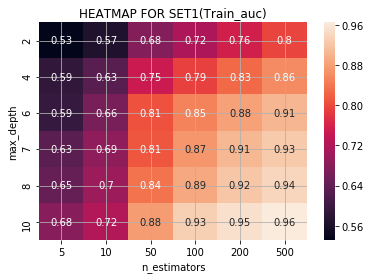

In [360]:
sns.heatmap(Train_auc,annot=True,xticklabels=[5, 10, 50, 100, 200, 500], yticklabels=[2, 4,6, 7, 8, 10],)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("HEATMAP FOR SET1(Train_auc)")
plt.grid()
plt.show()

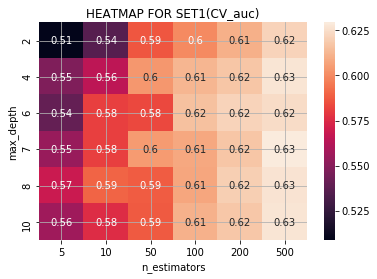

In [361]:
sns.heatmap(Cv_auc,annot=True,xticklabels=[5, 10, 50, 100, 200, 500], yticklabels=[2, 4,6, 7, 8, 10],)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("HEATMAP FOR SET1(CV_auc)")
plt.grid()
plt.show()

In [362]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
Estimator = [5,5,5,5,5,5, 10,10,10,10,10,10,50,50,50,50,50,50,100,100,100,100,100,100,200,200,200,200,200, 200,500,500,500,500,500,500]
Depth = [2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10]
#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable
x = PrettyTable()
column_names = ['Estimator','Depth','train_auc','cv_auc']
x.add_column(column_names[0],Estimator)
x.add_column(column_names[1],Depth)
x.add_column(column_names[2],train_auc)
x.add_column(column_names[3],cv_auc)
print(x)

+-----------+-------+--------------------+--------------------+
| Estimator | Depth |     train_auc      |       cv_auc       |
+-----------+-------+--------------------+--------------------+
|     5     |   2   | 0.5318565768956652 | 0.5087754951465097 |
|     5     |   4   | 0.568519555925557  | 0.5357827859223596 |
|     5     |   6   | 0.676420744279511  | 0.5867481872457928 |
|     5     |   7   |  0.71711293461911  | 0.6001863661564286 |
|     5     |   8   | 0.7562569004774243 | 0.6107390920918461 |
|     5     |   10  | 0.7963227477291518 | 0.6214526735681232 |
|     10    |   2   | 0.5887564877444441 | 0.5475425091956857 |
|     10    |   4   | 0.6331183334553135 | 0.5648613200223344 |
|     10    |   6   | 0.7478246844679318 | 0.6036123216613023 |
|     10    |   7   | 0.7930071544163969 | 0.6126267263648965 |
|     10    |   8   | 0.8281435125624824 | 0.6173833909900561 |
|     10    |   10  | 0.8601845652222965 | 0.6272454245240194 |
|     50    |   2   | 0.5931815786688533

**Using Best hyperparameters Value – Training the Model** 

In [363]:
#Taking the Optimal hyperparameter from heatmap and Pretty table of Max depth , Max Split , Train and CV AUC
n_estimators = 100
max_depth = 10    

In [364]:
from sklearn.metrics import roc_auc_score
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

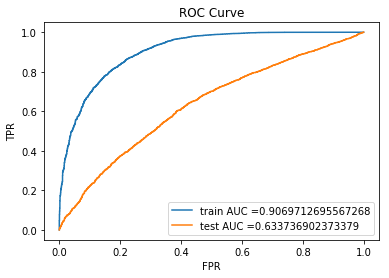

In [365]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


RF = RandomForestClassifier(n_estimators = 100, max_depth = 10)
RF.fit(X_train_bow, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_bow = batch_predict(RF, X_train_bow)
y_test_pred_bow = batch_predict(RF, X_test_bow)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_bow)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_bow)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.rcParams["figure.figsize"] = [5,5]
plt.show()

**Confusion Matrix**

**Train confusion matrix**

In [366]:
#https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
    
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


In [367]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
bow_train_confusion_matrix = confusion_matrix(y_train, predict(y_train_pred_bow, tr_thresholds, train_fpr, train_fpr))
print(bow_train_confusion_matrix)


Train confusion matrix
the maximum value of tpr*(1-fpr) 0.25 for threshold 0.829
[[ 1037  1037]
 [  147 11246]]


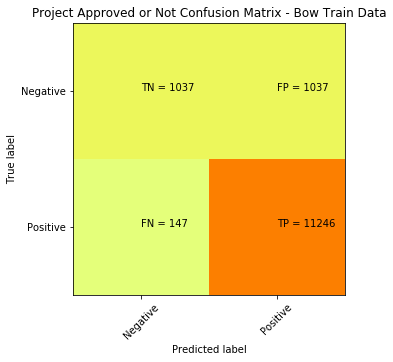

In [368]:
#http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

plt.clf()
plt.imshow(bow_train_confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Project Approved or Not Confusion Matrix - Bow Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(bow_train_confusion_matrix[i][j]))
plt.show()

**Test confusion matrix**

In [369]:
print("Train confusion matrix")
bow_test_confusion_matrix = confusion_matrix(y_test, predict(y_test_pred_bow, te_thresholds, test_fpr, test_fpr))
print(bow_test_confusion_matrix)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24999989250201562 for threshold 0.844
[[ 763  762]
 [2503 5872]]


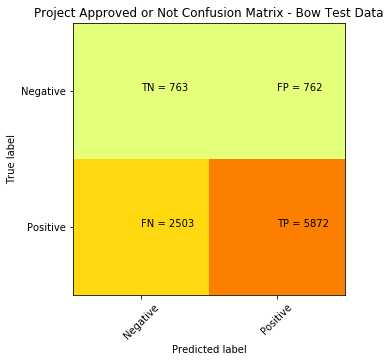

In [370]:
##http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

plt.clf()
plt.imshow(bow_test_confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Project Approved or Not Confusion Matrix - Bow Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(bow_test_confusion_matrix[i][j]))
plt.show()

### 2.4.2 Applying Random Forest  on TFIDF,<font color='red'> SET 2</font>



In [371]:
X_train_tfidf = hstack((cat_nc_train, cat_pc_train,subcat_nc_train,subcat_pc_train,school_state_nc_train,school_state_pc_train,teacher_prefix_clean_nc_train,teacher_prefix_clean_pc_train,project_grade_category_nc_train,project_grade_category_pc_train,tfidf_essays_train,tfidf_title_train,price_train,prev_post_train,title_word_count_train,essay_word_count_train)).tocsr()
X_train_tfidf.shape

(13467, 7957)

In [372]:
X_cv_tfidf = hstack((cat_nc_cv, cat_pc_cv,subcat_nc_cv,subcat_pc_cv,school_state_nc_cv,school_state_pc_cv,teacher_prefix_clean_nc_cv,teacher_prefix_clean_pc_cv,project_grade_category_nc_cv,project_grade_category_pc_cv,tfidf_essays_cv,tfidf_title_cv,price_cv,prev_post_cv,title_word_count_cv,essay_word_count_cv)).tocsr()
X_cv_tfidf.shape

(6633, 7957)

In [373]:
X_test_tfidf = hstack((cat_nc_test, cat_pc_test,subcat_nc_test,subcat_pc_test,school_state_nc_test,school_state_pc_test,teacher_prefix_clean_nc_test,teacher_prefix_clean_pc_test,project_grade_category_nc_test,project_grade_category_pc_test,tfidf_essays_test,tfidf_title_test,price_test,prev_post_test,title_word_count_test,essay_word_count_test)).tocsr()
X_test_tfidf.shape

(9900, 7957)

**GridSearchCV - Finding the best hyper parameter That maximum AUC value**

In [375]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

RF = RandomForestClassifier()
n_estimators = [5, 10, 50, 100, 200, 500]
max_depth = [2, 4,6, 7, 8, 10]
    
tuned_parameters = [{'n_estimators':n_estimators,'max_depth': max_depth}]

clf = GridSearchCV(RF,tuned_parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_tfidf, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
Train_auc = train_auc.reshape(len(n_estimators),len(max_depth)) 
Cv_auc = cv_auc.reshape(len(n_estimators),len(max_depth))  

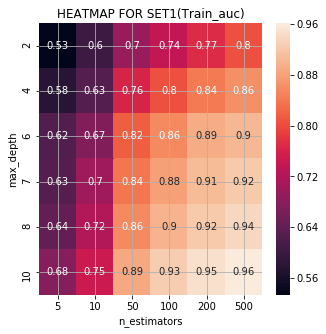

In [376]:
sns.heatmap(Train_auc,annot=True,xticklabels=[5, 10, 50, 100, 200, 500], yticklabels=[2, 4,6, 7, 8, 10],)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("HEATMAP FOR SET1(Train_auc)")
plt.grid()
plt.show()

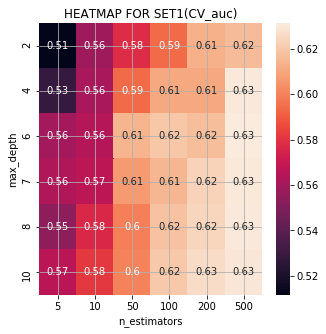

In [378]:
sns.heatmap(Cv_auc,annot=True,xticklabels=[5, 10, 50, 100, 200, 500], yticklabels=[2, 4,6, 7, 8, 10],)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("HEATMAP FOR SET1(CV_auc)")
plt.grid()
plt.show()

In [379]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
Estimator = [5,5,5,5,5,5, 10,10,10,10,10,10,50,50,50,50,50,50,100,100,100,100,100,100,200,200,200,200,200, 200,500,500,500,500,500,500]
Depth = [2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10]
#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable
x = PrettyTable()
column_names = ['Estimator','Depth','train_auc','cv_auc']
x.add_column(column_names[0],Estimator)
x.add_column(column_names[1],Depth)
x.add_column(column_names[2],train_auc)
x.add_column(column_names[3],cv_auc)
print(x)

+-----------+-------+--------------------+--------------------+
| Estimator | Depth |     train_auc      |       cv_auc       |
+-----------+-------+--------------------+--------------------+
|     5     |   2   | 0.5336854133907104 | 0.5115859379385037 |
|     5     |   4   | 0.6029872032636211 | 0.5585076249438626 |
|     5     |   6   | 0.695848756192324  | 0.5782430108000386 |
|     5     |   7   | 0.7376796049160327 | 0.5941995300205333 |
|     5     |   8   | 0.7703367503500423 | 0.6133071508306305 |
|     5     |   10  | 0.8043736428039764 | 0.6164919241176694 |
|     10    |   2   | 0.5798608422764221 | 0.5284866867702054 |
|     10    |   4   | 0.6282154879133269 | 0.5615631614440417 |
|     10    |   6   | 0.7621815441183668 | 0.5941625323382056 |
|     10    |   7   | 0.8047754075669525 | 0.6110214340175727 |
|     10    |   8   | 0.8417651113740868 | 0.6110774486381443 |
|     10    |   10  | 0.8611951337736757 | 0.6307115501379074 |
|     50    |   2   | 0.6249485505317912

**Using Best Hyperparameters Value – Training the Model** 

In [380]:
#Taking the Optimal hyperparameter from heatmap and Pretty table of Max depth , Max Split , Train and CV AUC
n_estimators = 50
max_depth = 10


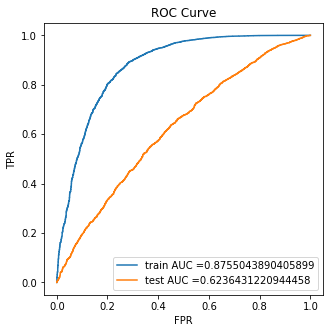

In [381]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

RF = RandomForestClassifier(n_estimators = 50, max_depth = 10)
RF.fit(X_train_tfidf, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_tfidf = batch_predict(RF, X_train_tfidf)
y_test_pred_tfidf = batch_predict(RF, X_test_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidf)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidf)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.rcParams["figure.figsize"] = [5,5]
plt.show()


**Confusion Matrix**

**Train confusion matrix**

In [382]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
tfidf_train_confusion_matrix = confusion_matrix(y_train, predict(y_train_pred_tfidf, tr_thresholds, train_fpr, train_fpr))
print(tfidf_train_confusion_matrix)


Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24999976752166 for threshold 0.823
[[ 1038  1036]
 [  266 11127]]


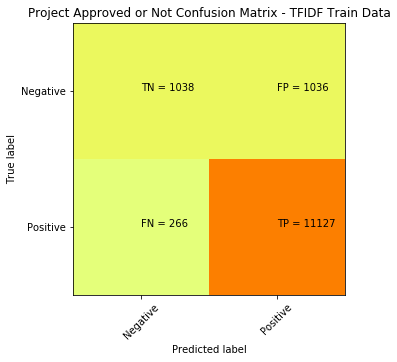

In [383]:
#http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

plt.clf()
plt.imshow(tfidf_train_confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Project Approved or Not Confusion Matrix - TFIDF Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(tfidf_train_confusion_matrix[i][j]))
plt.show()

**Test confusion matrix**

In [384]:
print("Test confusion matrix")
tfidf_test_confusion_matrix = confusion_matrix(y_test, predict(y_test_pred_tfidf, te_thresholds, test_fpr, test_fpr))
print(tfidf_test_confusion_matrix)

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999989250201562 for threshold 0.846
[[ 763  762]
 [2717 5658]]


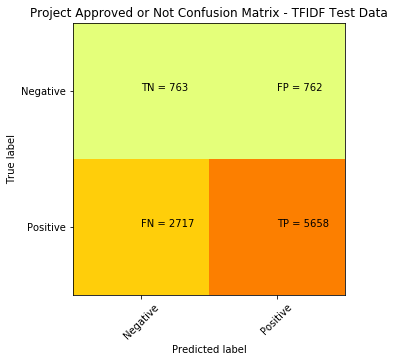

In [385]:
##http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

plt.clf()
plt.imshow(tfidf_test_confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Project Approved or Not Confusion Matrix - TFIDF Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(tfidf_test_confusion_matrix[i][j]))
plt.show()

### 2.4.3 Applying Random Forest  on AVG W2V,<font color='red'> SET 3</font>

In [386]:
X_train_avg_w2v = np.hstack((cat_nc_train, cat_pc_train,subcat_nc_train,subcat_pc_train,school_state_nc_train,school_state_pc_train,teacher_prefix_clean_nc_train,teacher_prefix_clean_pc_train,project_grade_category_nc_train,project_grade_category_pc_train,avg_w2v_essays_train,avg_w2v_title_train,price_train,prev_post_train,title_word_count_train,essay_word_count_train))
X_train_avg_w2v.shape

(13467, 614)

In [387]:
X_cv_avg_w2v = np.hstack((cat_nc_cv, cat_pc_cv,subcat_nc_cv,subcat_pc_cv,school_state_nc_cv,school_state_pc_cv,teacher_prefix_clean_nc_cv,teacher_prefix_clean_pc_cv,project_grade_category_nc_cv,project_grade_category_pc_cv,avg_w2v_essays_cv,avg_w2v_title_cv,price_cv,prev_post_cv,title_word_count_cv,essay_word_count_cv))
X_cv_avg_w2v.shape

(6633, 614)

In [388]:
X_test_avg_w2v = np.hstack((cat_nc_test, cat_pc_test,subcat_nc_test,subcat_pc_test,school_state_nc_test,school_state_pc_test,teacher_prefix_clean_nc_test,teacher_prefix_clean_pc_test,project_grade_category_nc_test,project_grade_category_pc_test,avg_w2v_essays_test,avg_w2v_title_test,price_test,prev_post_test,title_word_count_test,essay_word_count_test))
X_test_avg_w2v.shape

(9900, 614)

**GridSearchCV - Finding the best hyper parameter That maximum AUC value**

In [389]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


RF = RandomForestClassifier()
n_estimators = [5, 10, 50, 100, 200, 500]
max_depth = [2, 4,6, 7, 8, 10]
    
tuned_parameters = [{'n_estimators':n_estimators,'max_depth': max_depth}]

clf = GridSearchCV(RF,tuned_parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_avg_w2v, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
Train_auc = train_auc.reshape(len(n_estimators),len(max_depth)) 
Cv_auc = cv_auc.reshape(len(n_estimators),len(max_depth)) 



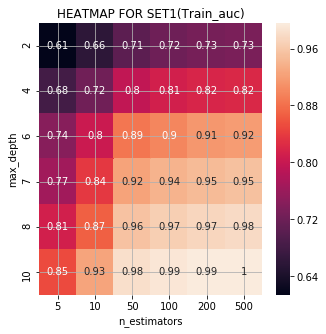

In [391]:
sns.heatmap(Train_auc,annot=True,xticklabels=[5, 10, 50, 100, 200, 500], yticklabels=[2, 4,6, 7, 8, 10],)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("HEATMAP FOR SET1(Train_auc)")
plt.grid()
plt.show()

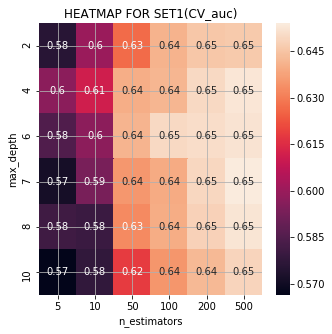

In [392]:
sns.heatmap(Cv_auc,annot=True,xticklabels=[5, 10, 50, 100, 200, 500], yticklabels=[2, 4,6, 7, 8, 10],)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("HEATMAP FOR SET1(CV_auc)")
plt.grid()

In [393]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
Estimator = [5,5,5,5,5,5, 10,10,10,10,10,10,50,50,50,50,50,50,100,100,100,100,100,100,200,200,200,200,200, 200,500,500,500,500,500,500]
Depth = [2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10]
#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable
x = PrettyTable()
column_names = ['Estimator','Depth','train_auc','cv_auc']
x.add_column(column_names[0],Estimator)
x.add_column(column_names[1],Depth)
x.add_column(column_names[2],train_auc)
x.add_column(column_names[3],cv_auc)
print(x)

+-----------+-------+--------------------+--------------------+
| Estimator | Depth |     train_auc      |       cv_auc       |
+-----------+-------+--------------------+--------------------+
|     5     |   2   | 0.6140498025575623 | 0.5758473331637584 |
|     5     |   4   | 0.6589803415997196 | 0.6002132067226466 |
|     5     |   6   | 0.7052450375944321 | 0.6268837542991728 |
|     5     |   7   | 0.7219076868030223 | 0.6413574708645524 |
|     5     |   8   | 0.7290862518586579 | 0.6457793897748885 |
|     5     |   10  | 0.7327496419827148 | 0.6463106160630236 |
|     10    |   2   | 0.6819579468688035 | 0.5969417548215057 |
|     10    |   4   | 0.7229567628964068 | 0.6113153133892752 |
|     10    |   6   |  0.79584705196743  | 0.6400954374888248 |
|     10    |   7   | 0.8118794963697876 | 0.6418137431871942 |
|     10    |   8   | 0.8197364496893144 | 0.6497907460852735 |
|     10    |   10  | 0.8223282831948672 | 0.6529267711200621 |
|     50    |   2   | 0.7439352316016087

**Using Best Hyper parameters Value – Training the Model** 

In [394]:
#Taking the Optimal hyperparameter from heatmap and Pretty table of Max depth , Max Split , Train and CV AUC
n_estimators = 200
max_depth = 10

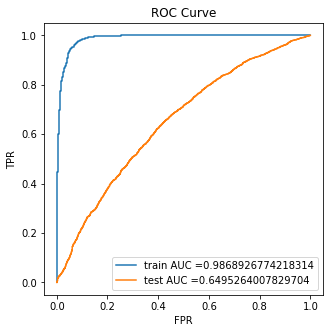

In [395]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


RF = RandomForestClassifier(n_estimators = 200, max_depth = 10)
RF.fit(X_train_avg_w2v, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_avg_w2v = batch_predict(RF,X_train_avg_w2v)
y_test_pred_avg_w2v = batch_predict(RF,X_test_avg_w2v)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_avg_w2v)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_avg_w2v)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

plt.show()

**Confusion Matrix**

**Train confusion matrix**

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.21834551674820457 for threshold 0.759
[[ 1406   668]
 [    1 11392]]


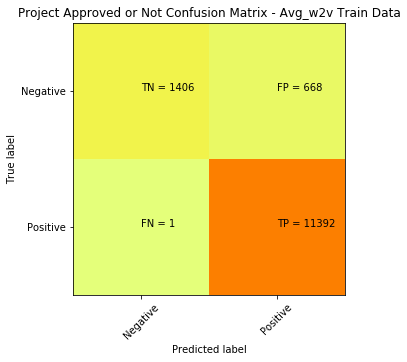

In [396]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
avg_w2v_train_confusion_matrix = confusion_matrix(y_train, predict(y_train_pred_avg_w2v, tr_thresholds, train_fpr, train_fpr))
print(avg_w2v_train_confusion_matrix)

#http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

plt.clf()
plt.imshow(avg_w2v_train_confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Project Approved or Not Confusion Matrix - Avg_w2v Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(avg_w2v_train_confusion_matrix[i][j]))
plt.show()

**Test confusion matrix**

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999989250201562 for threshold 0.837
[[ 763  762]
 [2391 5984]]


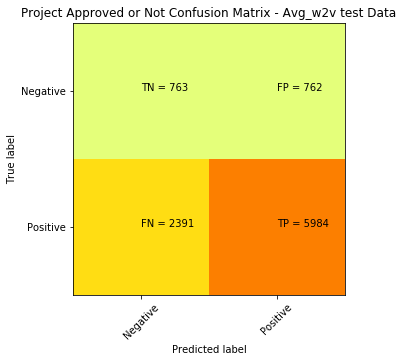

In [397]:
from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
avg_w2v_test_confusion_matrix = confusion_matrix(y_test, predict(y_test_pred_avg_w2v, te_thresholds, test_fpr, test_fpr))
print(avg_w2v_test_confusion_matrix)

#http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

plt.clf()
plt.imshow(avg_w2v_test_confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Project Approved or Not Confusion Matrix - Avg_w2v test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(avg_w2v_test_confusion_matrix[i][j]))
plt.show()

### 2.4.4 Applying Random Forest  on TFIDF W2V,<font color='red'> SET 4</font>

In [402]:
X_train_tfidf_w2v = np.hstack((cat_nc_train, cat_pc_train,subcat_nc_train,subcat_pc_train,school_state_nc_train,school_state_pc_train,teacher_prefix_clean_nc_train,teacher_prefix_clean_pc_train,project_grade_category_nc_train,project_grade_category_pc_train,tfidf_w2v_essays_train,tfidf_w2v_title_train,price_train,prev_post_train,title_word_count_train,essay_word_count_train))
X_train_tfidf_w2v.shape


(13467, 614)

In [403]:
X_cv_tfidf_w2v = np.hstack((cat_nc_cv, cat_pc_cv,subcat_nc_cv,subcat_pc_cv,school_state_nc_cv,school_state_pc_cv,teacher_prefix_clean_nc_cv,teacher_prefix_clean_pc_cv,project_grade_category_nc_cv,project_grade_category_pc_cv,tfidf_w2v_essays_cv,tfidf_w2v_title_cv,price_cv,prev_post_cv,title_word_count_cv,essay_word_count_cv))
X_cv_tfidf_w2v.shape


(6633, 614)

In [404]:
X_test_tfidf_w2v = np.hstack((cat_nc_test, cat_pc_test,subcat_nc_test,subcat_pc_test,school_state_nc_test,school_state_pc_test,teacher_prefix_clean_nc_test,teacher_prefix_clean_pc_test,project_grade_category_nc_test,project_grade_category_pc_test,tfidf_w2v_essays_test,tfidf_w2v_title_test,price_test,prev_post_test,title_word_count_test,essay_word_count_test))
X_test_tfidf_w2v.shape


(9900, 614)

**GridSearchCV - Finding the best hyper parameter That maximum AUC value**

In [405]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

RF = RandomForestClassifier()
n_estimators = [5, 10, 50, 100, 200, 500]
max_depth = [2, 4,6, 7, 8, 10]
    
tuned_parameters = [{'n_estimators':n_estimators,'max_depth': max_depth}]

clf = GridSearchCV(RF,tuned_parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_tfidf_w2v, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
Train_auc = train_auc.reshape(len(n_estimators),len(max_depth)) 
Cv_auc = cv_auc.reshape(len(n_estimators),len(max_depth)) 

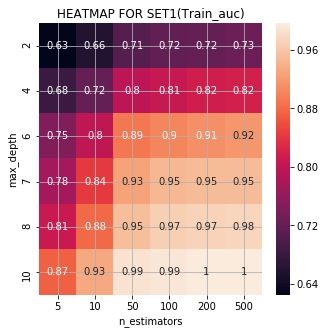

In [406]:
sns.heatmap(Train_auc,annot=True,xticklabels=[5, 10, 50, 100, 200, 500], yticklabels=[2, 4,6, 7, 8, 10],)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("HEATMAP FOR SET1(Train_auc)")
plt.grid()
plt.show()


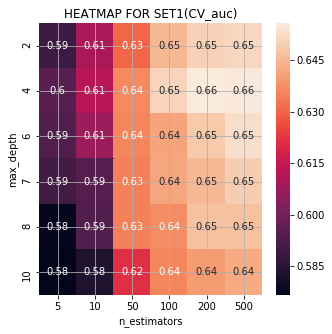

In [407]:
sns.heatmap(Cv_auc,annot=True,xticklabels=[5, 10, 50, 100, 200, 500], yticklabels=[2, 4,6, 7, 8, 10],)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("HEATMAP FOR SET1(CV_auc)")
plt.grid()
plt.show()

In [408]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
Estimator = [5,5,5,5,5,5, 10,10,10,10,10,10,50,50,50,50,50,50,100,100,100,100,100,100,200,200,200,200,200, 200,500,500,500,500,500,500]
Depth = [2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10]
#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable
x = PrettyTable()
column_names = ['Estimator','Depth','train_auc','cv_auc']
x.add_column(column_names[0],Estimator)
x.add_column(column_names[1],Depth)
x.add_column(column_names[2],train_auc)
x.add_column(column_names[3],cv_auc)
print(x)

+-----------+-------+--------------------+--------------------+
| Estimator | Depth |     train_auc      |       cv_auc       |
+-----------+-------+--------------------+--------------------+
|     5     |   2   | 0.6250932472605791 | 0.589349993450807  |
|     5     |   4   | 0.658817469315851  | 0.6098286280527782 |
|     5     |   6   | 0.7069916516057976 | 0.6301480621032602 |
|     5     |   7   | 0.7181054703891122 | 0.6450902891558499 |
|     5     |   8   | 0.7217390406034467 | 0.6503411317734926 |
|     5     |   10  | 0.7275513626106115 | 0.6517494110467489 |
|     10    |   2   | 0.6830836861360453 | 0.595145240168593  |
|     10    |   4   | 0.7219304313273446 | 0.6122965410210867 |
|     10    |   6   | 0.7971596757198319 | 0.6364996830528195 |
|     10    |   7   | 0.8066598156475626 | 0.6510472498740327 |
|     10    |   8   | 0.8160675363720417 | 0.6557678825265192 |
|     10    |   10  | 0.8185326252779069 | 0.6551517727663048 |
|     50    |   2   | 0.7464099633733953

**Using Best Hyper parameters Value – Training the Model** 

In [409]:
#Taking the Optimal hyperparameter from heatmap and Pretty table of Max depth , Max Split , Train and CV AUC
n_estimators = 50
max_depth = 10

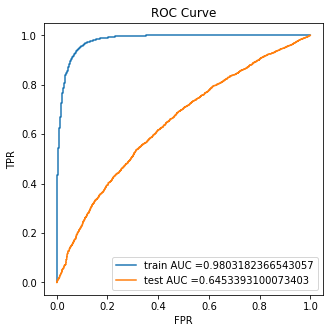

In [410]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

RF = RandomForestClassifier(n_estimators = 50, max_depth = 10)
RF.fit(X_train_tfidf_w2v, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_tfidf_w2v = batch_predict(RF,X_train_tfidf_w2v)
y_test_pred_tfidf_w2v = batch_predict(RF,X_test_tfidf_w2v)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidf_w2v)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidf_w2v)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

plt.show()




**Confusion Matrix**

**Train confusion matrix**

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.23770189581436696 for threshold 0.736
[[ 1267   807]
 [    1 11392]]


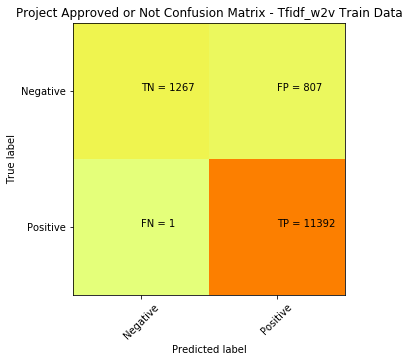

In [411]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
tfidf_w2v_train_confusion_matrix = confusion_matrix(y_train, predict(y_train_pred_tfidf_w2v, tr_thresholds, train_fpr, train_fpr))
print(tfidf_w2v_train_confusion_matrix)

#http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

plt.clf()
plt.imshow(tfidf_w2v_train_confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Project Approved or Not Confusion Matrix - Tfidf_w2v Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(tfidf_w2v_train_confusion_matrix[i][j]))
plt.show()

**Test confusion matrix**

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999989250201562 for threshold 0.834
[[ 763  762]
 [2475 5900]]


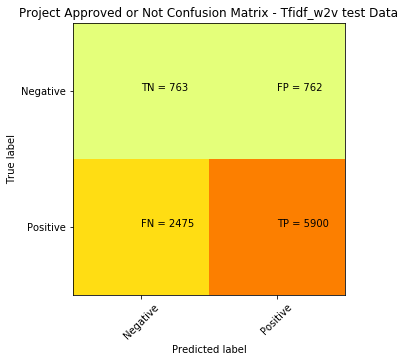

In [412]:
from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
tfidf_w2v_test_confusion_matrix = confusion_matrix(y_test, predict(y_test_pred_tfidf_w2v, te_thresholds, test_fpr, test_fpr))
print(tfidf_w2v_test_confusion_matrix)

#http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

plt.clf()
plt.imshow(avg_w2v_test_confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Project Approved or Not Confusion Matrix - Tfidf_w2v test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(tfidf_w2v_test_confusion_matrix[i][j]))
plt.show()

<h2>2.5 Appling GBDT on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations


### 2.5.1 Applying GBDT  on BOW,<font color='red'> SET 1</font>

**GridSearchCV - Finding the best hyper parameter That maximum AUC value**

In [413]:
from sklearn.ensemble import GradientBoostingClassifier

**CV_With max_depth andn_estimators**

In [414]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

GBDT =  GradientBoostingClassifier()

n_estimators = [5, 10, 50, 100, 200, 500]
max_depth = [2, 4,6, 7, 8, 10]
    
tuned_parameters = [{'n_estimators':n_estimators,'max_depth': max_depth}]

clf = GridSearchCV(GBDT,tuned_parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_bow, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
Train_auc = train_auc.reshape(len(n_estimators),len(max_depth)) 
Cv_auc = cv_auc.reshape(len(n_estimators),len(max_depth)) 

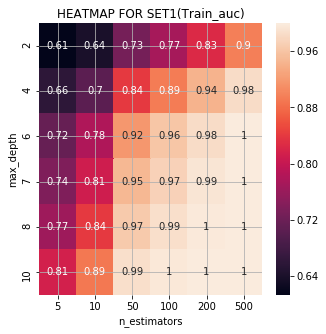

In [415]:
sns.heatmap(Train_auc,annot=True,xticklabels=[5, 10, 50, 100, 200, 500], yticklabels=[2, 4,6, 7, 8, 10],)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("HEATMAP FOR SET1(Train_auc)")
plt.grid()
plt.show()

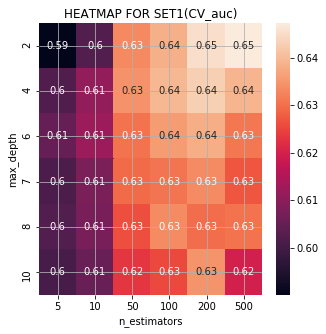

In [416]:
sns.heatmap(Cv_auc,annot=True,xticklabels=[5, 10, 50, 100, 200, 500], yticklabels=[2, 4,6, 7, 8, 10],)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("HEATMAP FOR SET1(CV_auc)")
plt.grid()
plt.show()

In [417]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
Estimator = [5,5,5,5,5,5, 10,10,10,10,10,10,50,50,50,50,50,50,100,100,100,100,100,100,200,200,200,200,200, 200,500,500,500,500,500,500]
Depth = [2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10]
#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable
x = PrettyTable()
column_names = ['Estimator','Depth','train_auc','cv_auc']
x.add_column(column_names[0],Estimator)
x.add_column(column_names[1],Depth)
x.add_column(column_names[2],train_auc)
x.add_column(column_names[3],cv_auc)
print(x)

+-----------+-------+--------------------+--------------------+
| Estimator | Depth |     train_auc      |       cv_auc       |
+-----------+-------+--------------------+--------------------+
|     5     |   2   | 0.6135798993487369 | 0.5900810586215375 |
|     5     |   4   | 0.6396814052438499 | 0.6022426804148265 |
|     5     |   6   | 0.7283602148749947 | 0.6333848872627319 |
|     5     |   7   | 0.7731841244004197 | 0.6384530531011717 |
|     5     |   8   | 0.8251532527914116 | 0.6454399151310238 |
|     5     |   10  | 0.896799317450692  | 0.6472452879456427 |
|     10    |   2   | 0.6600770758174382 | 0.6020706761707133 |
|     10    |   4   | 0.7043154399845122 | 0.6112773089762483 |
|     10    |   6   | 0.8401820433671201 | 0.6344005384476638 |
|     10    |   7   | 0.8942736368661212 | 0.6395195584776616 |
|     10    |   8   | 0.9428390864960493 | 0.6429394330878129 |
|     10    |   10  | 0.9848322673378914 | 0.6389892237062716 |
|     50    |   2   | 0.716107690414637 

**Using Best hyperparameters Value – Training the Model** 

In [418]:
#Taking the Optimal hyperparameter from heatmap and Pretty table of Max depth , Max Split , Train and CV AUC
n_estimators = 50
max_depth = 10

In [419]:
from sklearn.metrics import roc_auc_score
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

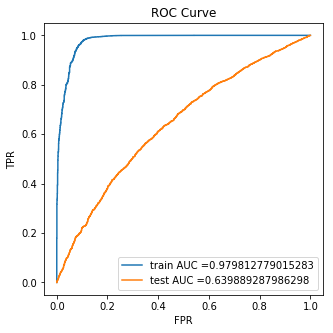

In [421]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


GBDT =  GradientBoostingClassifier(n_estimators = 50, max_depth = 10)
GBDT.fit(X_train_bow, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_bow = batch_predict(GBDT, X_train_bow)
y_test_pred_bow = batch_predict(GBDT, X_test_bow)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_bow)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_bow)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.rcParams["figure.figsize"] = [5,5]
plt.show()

**Confusion Matrix**

**Train confusion matrix**


In [422]:
#https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
    
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


In [423]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
bow_train_confusion_matrix = confusion_matrix(y_train, predict(y_train_pred_bow, tr_thresholds, train_fpr, train_fpr))
print(bow_train_confusion_matrix)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2481996877350937 for threshold 0.608
[[  949  1125]
 [    1 11392]]


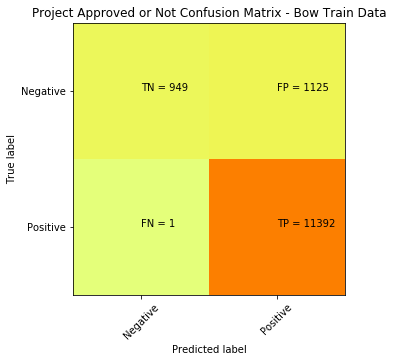

In [424]:
#http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

plt.clf()
plt.imshow(bow_train_confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Project Approved or Not Confusion Matrix - Bow Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(bow_train_confusion_matrix[i][j]))
plt.show()

**Test confusion matrix**

In [425]:
print("Train confusion matrix")
bow_test_confusion_matrix = confusion_matrix(y_test, predict(y_test_pred_bow, te_thresholds, test_fpr, test_fpr))
print(bow_test_confusion_matrix)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24999989250201562 for threshold 0.848
[[ 763  762]
 [2531 5844]]


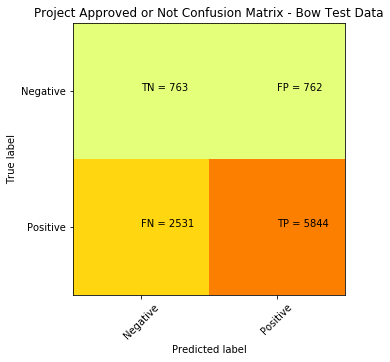

In [426]:
##http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

plt.clf()
plt.imshow(bow_test_confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Project Approved or Not Confusion Matrix - Bow Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(bow_test_confusion_matrix[i][j]))
plt.show()

### 2.5.2 Applying GBDT on TFIDF,<font color='red'> SET 2</font>

**GridSearchCV - Finding the best hyper parameter That maximum AUC value**


**CV_With max_depth andn_estimators**

In [427]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

GBDT =  GradientBoostingClassifier()

n_estimators = [5, 10, 50, 100, 200, 500]
max_depth = [2, 4,6, 7, 8, 10]
    
tuned_parameters = [{'n_estimators':n_estimators,'max_depth': max_depth}]

clf = GridSearchCV(GBDT,tuned_parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_tfidf, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
Train_auc = train_auc.reshape(len(n_estimators),len(max_depth)) 
Cv_auc = cv_auc.reshape(len(n_estimators),len(max_depth))  

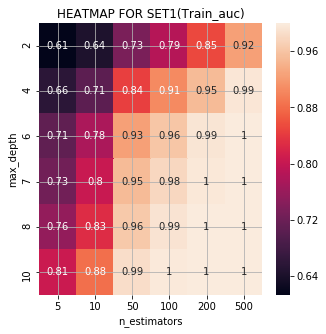

In [428]:
sns.heatmap(Train_auc,annot=True,xticklabels=[5, 10, 50, 100, 200, 500], yticklabels=[2, 4,6, 7, 8, 10],)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("HEATMAP FOR SET1(Train_auc)")
plt.grid()
plt.show()

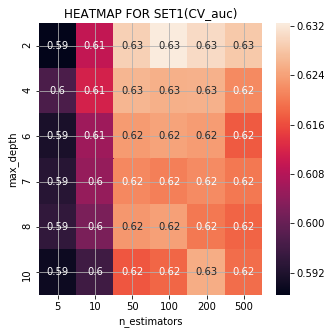

In [429]:
sns.heatmap(Cv_auc,annot=True,xticklabels=[5, 10, 50, 100, 200, 500], yticklabels=[2, 4,6, 7, 8, 10],)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("HEATMAP FOR SET1(CV_auc)")
plt.grid()
plt.show()

In [430]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
Estimator = [5,5,5,5,5,5, 10,10,10,10,10,10,50,50,50,50,50,50,100,100,100,100,100,100,200,200,200,200,200, 200,500,500,500,500,500,500]
Depth = [2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10]
#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable
x = PrettyTable()
column_names = ['Estimator','Depth','train_auc','cv_auc']
x.add_column(column_names[0],Estimator)
x.add_column(column_names[1],Depth)
x.add_column(column_names[2],train_auc)
x.add_column(column_names[3],cv_auc)
print(x)

+-----------+-------+--------------------+--------------------+
| Estimator | Depth |     train_auc      |       cv_auc       |
+-----------+-------+--------------------+--------------------+
|     5     |   2   | 0.6134739201267729 | 0.5884054292913363 |
|     5     |   4   | 0.643796051935985  | 0.6095372345704158 |
|     5     |   6   | 0.7332511938787784 | 0.6292147456818298 |
|     5     |   7   | 0.7858767736109225 | 0.6324610671303218 |
|     5     |   8   | 0.8529338364854452 | 0.6304247643866667 |
|     5     |   10  | 0.9245295155296706 | 0.6284961089590181 |
|     10    |   2   | 0.6584392548633636 | 0.5971283049386252 |
|     10    |   4   | 0.7056632101393774 | 0.6115025734848871 |
|     10    |   6   | 0.8447445125819436 | 0.6263271808247584 |
|     10    |   7   | 0.9063132829054347 | 0.6256861423367419 |
|     10    |   8   | 0.9515420690180488 | 0.6258751527353809 |
|     10    |   10  | 0.9949546440382132 | 0.6217272867585176 |
|     50    |   2   | 0.7095646657063089

**Using Best hyperparameters Value – Training the Model** 

In [439]:
#Taking the Optimal hyperparameter from heatmap and Pretty table of Max depth , Max Split , Train and CV AUC
n_estimators = 100
max_depth = 10

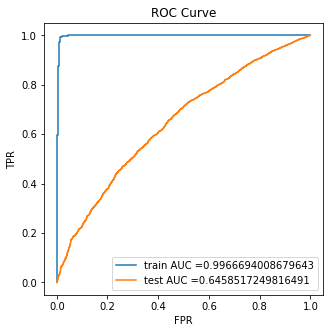

In [440]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

GBDT =  GradientBoostingClassifier(n_estimators = 100, max_depth = 10)
GBDT.fit(X_train_tfidf, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_tfidf = batch_predict(GBDT, X_train_tfidf)
y_test_pred_tfidf = batch_predict(GBDT, X_test_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidf)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidf)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.rcParams["figure.figsize"] = [5,5]
plt.show()

**Confusion Matrix**

**Train confusion matrix**

In [441]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
tfidf_train_confusion_matrix = confusion_matrix(y_train, predict(y_train_pred_tfidf, tr_thresholds, train_fpr, train_fpr))
print(tfidf_train_confusion_matrix)

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.09444316323048181 for threshold 0.728
[[ 1855   219]
 [    1 11392]]


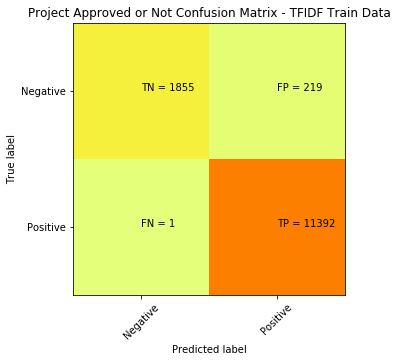

In [442]:
#http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

plt.clf()
plt.imshow(tfidf_train_confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Project Approved or Not Confusion Matrix - TFIDF Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(tfidf_train_confusion_matrix[i][j]))
plt.show()

**Test confusion matrix**

In [443]:
print("Test confusion matrix")
tfidf_test_confusion_matrix = confusion_matrix(y_test, predict(y_test_pred_tfidf, te_thresholds, test_fpr, test_fpr))
print(tfidf_test_confusion_matrix)

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999989250201562 for threshold 0.859
[[ 763  762]
 [2434 5941]]


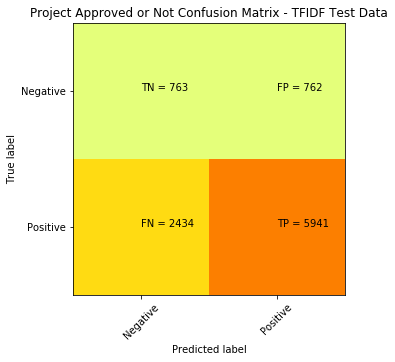

In [444]:
##http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

plt.clf()
plt.imshow(tfidf_test_confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Project Approved or Not Confusion Matrix - TFIDF Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(tfidf_test_confusion_matrix[i][j]))
plt.show()

### 2.5.3 Applying GBDT on AVG W2V,<font color='red'> SET 3</font>


**GridSearchCV - Finding the best hyper parameter That maximum AUC value**

**CV_With max_depth and n_estimators**

In [431]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


GBDT =  GradientBoostingClassifier()

n_estimators = [5, 10, 50, 100, 200, 500]
max_depth = [2, 4,6, 7, 8, 10]
    
tuned_parameters = [{'n_estimators':n_estimators,'max_depth': max_depth}]

clf = GridSearchCV(GBDT,tuned_parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_avg_w2v, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
Train_auc = train_auc.reshape(len(n_estimators),len(max_depth)) 
Cv_auc = cv_auc.reshape(len(n_estimators),len(max_depth)) 


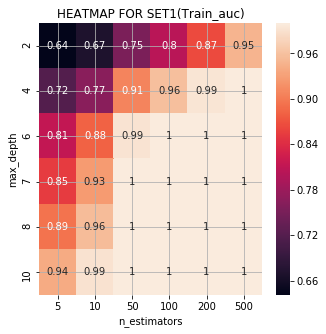

In [432]:
sns.heatmap(Train_auc,annot=True,xticklabels=[5, 10, 50, 100, 200, 500], yticklabels=[2, 4,6, 7, 8, 10],)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("HEATMAP FOR SET1(Train_auc)")
plt.grid()
plt.show()

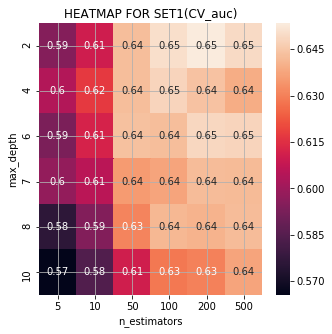

In [433]:
sns.heatmap(Cv_auc,annot=True,xticklabels=[5, 10, 50, 100, 200, 500], yticklabels=[2, 4,6, 7, 8, 10],)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("HEATMAP FOR SET1(CV_auc)")
plt.grid()

In [434]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
Estimator = [5,5,5,5,5,5, 10,10,10,10,10,10,50,50,50,50,50,50,100,100,100,100,100,100,200,200,200,200,200, 200,500,500,500,500,500,500]
Depth = [2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10]
#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable
x = PrettyTable()
column_names = ['Estimator','Depth','train_auc','cv_auc']
x.add_column(column_names[0],Estimator)
x.add_column(column_names[1],Depth)
x.add_column(column_names[2],train_auc)
x.add_column(column_names[3],cv_auc)
print(x)

+-----------+-------+--------------------+--------------------+
| Estimator | Depth |     train_auc      |       cv_auc       |
+-----------+-------+--------------------+--------------------+
|     5     |   2   | 0.6412070205581458 | 0.5949313541033646 |
|     5     |   4   | 0.6703783812072679 | 0.6105457785162287 |
|     5     |   6   | 0.7539662496625361 | 0.6429590540672157 |
|     5     |   7   | 0.8048944424018845 | 0.6506274031144375 |
|     5     |   8   | 0.8652844508009215 | 0.6534805196639738 |
|     5     |   10  | 0.9483516356668966 | 0.6494351173431445 |
|     10    |   2   | 0.7189190304502255 | 0.6042277995269233 |
|     10    |   4   | 0.7657530159973785 | 0.6172260219663711 |
|     10    |   6   | 0.907837316014047  | 0.6429170293971257 |
|     10    |   7   | 0.9591453950061247 | 0.6480740075159254 |
|     10    |   8   | 0.9930179266856153 |  0.64414638267793  |
|     10    |   10  | 0.9999932410517752 | 0.6393808834685978 |
|     50    |   2   | 0.812421695788756 

**Using Best hyperparameters Value – Training the Model** 

In [454]:
#Taking the Optimal hyperparameter from heatmap and Pretty table of Max depth , Max Split , Train and CV AUC
n_estimators = 10
max_depth = 50

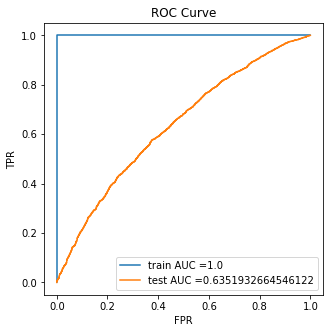

In [455]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


GBDT =  GradientBoostingClassifier(n_estimators = 50, max_depth = 10)
GBDT.fit(X_train_avg_w2v, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_avg_w2v = batch_predict(GBDT,X_train_avg_w2v)
y_test_pred_avg_w2v = batch_predict(GBDT,X_test_avg_w2v)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_avg_w2v)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_avg_w2v)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

plt.show()

**Confusion Matrix**

**Train confusion matrix**

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.0 for threshold 0.987
[[ 2074     0]
 [11392     1]]


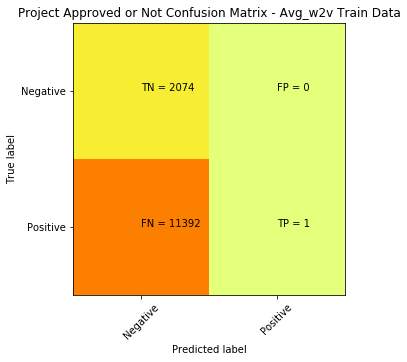

In [456]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
avg_w2v_train_confusion_matrix = confusion_matrix(y_train, predict(y_train_pred_avg_w2v, tr_thresholds, train_fpr, train_fpr))
print(avg_w2v_train_confusion_matrix)

#http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

plt.clf()
plt.imshow(avg_w2v_train_confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Project Approved or Not Confusion Matrix - Avg_w2v Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(avg_w2v_train_confusion_matrix[i][j]))
plt.show()

**Test confusion matrix**

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999989250201562 for threshold 0.9
[[ 763  762]
 [2665 5710]]


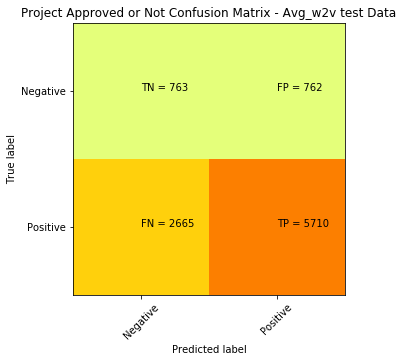

In [457]:
from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
avg_w2v_test_confusion_matrix = confusion_matrix(y_test, predict(y_test_pred_avg_w2v, te_thresholds, test_fpr, test_fpr))
print(avg_w2v_test_confusion_matrix)

#http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

plt.clf()
plt.imshow(avg_w2v_test_confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Project Approved or Not Confusion Matrix - Avg_w2v test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(avg_w2v_test_confusion_matrix[i][j]))
plt.show()

### 2.5.4 Applying GBDT on TFIDF W2V,<font color='red'> SET 4</font>

**GridSearchCV - Finding the best hyper parameter That maximum AUC value**

**CV_With max_depth andn_estimators**

In [435]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

GBDT =  GradientBoostingClassifier()

n_estimators = [5, 10, 50, 100, 200, 500]
max_depth = [2, 4,6, 7, 8, 10]
    
tuned_parameters = [{'n_estimators':n_estimators,'max_depth': max_depth}]

clf = GridSearchCV(GBDT,tuned_parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_tfidf_w2v, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
Train_auc = train_auc.reshape(len(n_estimators),len(max_depth)) 
Cv_auc = cv_auc.reshape(len(n_estimators),len(max_depth)) 

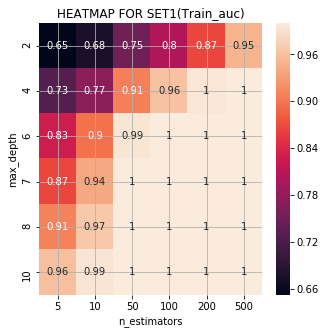

In [436]:
sns.heatmap(Train_auc,annot=True,xticklabels=[5, 10, 50, 100, 200, 500], yticklabels=[2, 4,6, 7, 8, 10],)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("HEATMAP FOR SET1(Train_auc)")
plt.grid()
plt.show()

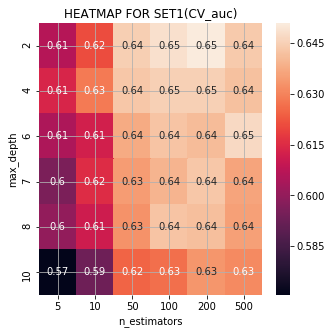

In [437]:
sns.heatmap(Cv_auc,annot=True,xticklabels=[5, 10, 50, 100, 200, 500], yticklabels=[2, 4,6, 7, 8, 10],)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("HEATMAP FOR SET1(CV_auc)")
plt.grid()
plt.show()

In [438]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
Estimator = [5,5,5,5,5,5, 10,10,10,10,10,10,50,50,50,50,50,50,100,100,100,100,100,100,200,200,200,200,200, 200,500,500,500,500,500,500]
Depth = [2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10,2, 4,6, 7, 8, 10]
#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable
x = PrettyTable()
column_names = ['Estimator','Depth','train_auc','cv_auc']
x.add_column(column_names[0],Estimator)
x.add_column(column_names[1],Depth)
x.add_column(column_names[2],train_auc)
x.add_column(column_names[3],cv_auc)
print(x)

+-----------+-------+--------------------+--------------------+
| Estimator | Depth |     train_auc      |       cv_auc       |
+-----------+-------+--------------------+--------------------+
|     5     |   2   | 0.6528482265545911 | 0.6066735653957752 |
|     5     |   4   | 0.6765503649134647 | 0.6209208357427772 |
|     5     |   6   | 0.7531322161025793 | 0.6447019835190594 |
|     5     |   7   | 0.8027175645234842 | 0.648583076284414  |
|     5     |   8   | 0.8658407284161705 | 0.6509814465125322 |
|     5     |   10  | 0.9510875885143367 | 0.6438653141871776 |
|     10    |   2   | 0.7294624632934236 | 0.6136236427823012 |
|     10    |   4   | 0.7722829363254022 | 0.6286018230001974 |
|     10    |   6   | 0.9074701169175153 | 0.6432489106811676 |
|     10    |   7   | 0.9633270443078729 | 0.6452112347392871 |
|     10    |   8   | 0.9954817183810775 | 0.6451788493124422 |
|     10    |   10  |        1.0         | 0.6420856882793449 |
|     50    |   2   | 0.8286951704062201

**Using Best hyperparameters Value – Training the Model** 

In [449]:
#Taking the Optimal hyperparameter from heatmap and Pretty table of Max depth , Max Split , Train and CV AUC
n_estimators = 100
max_depth = 5

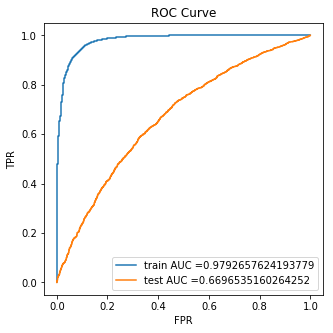

In [451]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


GBDT =  GradientBoostingClassifier(n_estimators = 100, max_depth = 5 )
GBDT.fit(X_train_tfidf_w2v, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_tfidf_w2v = batch_predict(GBDT,X_train_tfidf_w2v)
y_test_pred_tfidf_w2v = batch_predict(GBDT,X_test_tfidf_w2v)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidf_w2v)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidf_w2v)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

plt.show()



**Confusion Matrix**

**Train confusion matrix**

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24958990820825222 for threshold 0.57
[[ 1079   995]
 [    3 11390]]


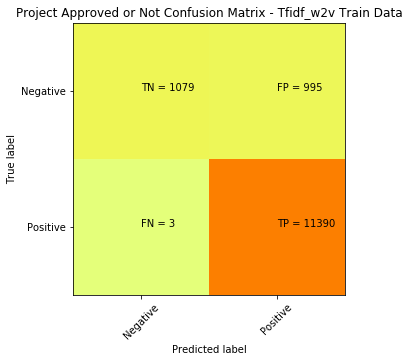

In [452]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
tfidf_w2v_train_confusion_matrix = confusion_matrix(y_train, predict(y_train_pred_tfidf_w2v, tr_thresholds, train_fpr, train_fpr))
print(tfidf_w2v_train_confusion_matrix)

#http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

plt.clf()
plt.imshow(tfidf_w2v_train_confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Project Approved or Not Confusion Matrix - Tfidf_w2v Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(tfidf_w2v_train_confusion_matrix[i][j]))
plt.show()

**Test confusion matrix**

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999989250201562 for threshold 0.833
[[ 763  762]
 [2115 6260]]


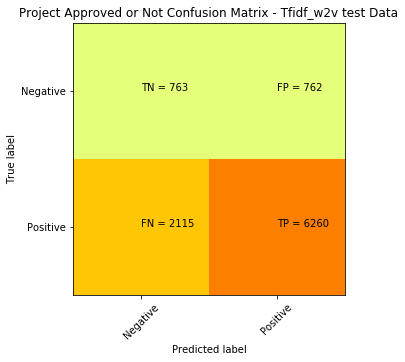

In [453]:
from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
tfidf_w2v_test_confusion_matrix = confusion_matrix(y_test, predict(y_test_pred_tfidf_w2v, te_thresholds, test_fpr, test_fpr))
print(tfidf_w2v_test_confusion_matrix)

#http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/

plt.clf()
plt.imshow(avg_w2v_test_confusion_matrix, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Project Approved or Not Confusion Matrix - Tfidf_w2v test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(tfidf_w2v_test_confusion_matrix[i][j]))
plt.show()

<h1>3. Conclusions</h1>

In [460]:
from prettytable import PrettyTable
#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper Parameter(Max depth & n_estimators )", "AUC"]
x.add_row(["BOW",  "Randon Forest  " , (10 , 100), 0.64])
x.add_row(["TFIDF", "Randon Forest  " , (10 ,  50), 0.63])
x.add_row(["AVG W2V", "Randon Forest  " , (10 , 200), 0.65])
x.add_row(["TFIDF W2V", "Randon Forest   " , (10 , 50), 0.65])
x.add_row(["BOW",  "GBDT  " , (10 , 50), 0.64])
x.add_row(["TFIDF", "GBDT  " , (10 ,  100), 0.65])
x.add_row(["AVG W2V", "GBDT  " , (10 , 50), 0.64])
x.add_row(["TFIDF W2V","GBDT   " , (5 , 100), 0.67])


print(x)

+------------+------------------+--------------------------------------------+------+
| Vectorizer |      Model       | Hyper Parameter(Max depth & n_estimators ) | AUC  |
+------------+------------------+--------------------------------------------+------+
|    BOW     | Randon Forest    |                 (10, 100)                  | 0.64 |
|   TFIDF    | Randon Forest    |                  (10, 50)                  | 0.63 |
|  AVG W2V   | Randon Forest    |                 (10, 200)                  | 0.65 |
| TFIDF W2V  | Randon Forest    |                  (10, 50)                  | 0.65 |
|    BOW     |      GBDT        |                  (10, 50)                  | 0.64 |
|   TFIDF    |      GBDT        |                 (10, 100)                  | 0.65 |
|  AVG W2V   |      GBDT        |                  (10, 50)                  | 0.64 |
| TFIDF W2V  |     GBDT         |                  (5, 100)                  | 0.67 |
+------------+------------------+---------------------